## Demonstration of Simple Spiking Neural Networks

explanitory text.

Below we first set up the notebook.

In [13]:
"""
Visualization of Dynamics of Simple Neural Networks
"""
import numpy as np
import scipy as sp
import timeit
import matplotlib.pyplot as plt
from importlib import reload 
from neuron import Neuron
from network import Network
from IPython.display import HTML

#default plot parameters
plotparams = {'figure.figsize': (10, 10),
    'axes.labelsize': '20',
    'axes.titlesize':'22',
    'xtick.labelsize':'20',
    'ytick.labelsize':'20',
    'lines.linewidth' : 3,
    'legend.fontsize': '18',
    'text.usetex': 'True',
    'xtick.major.size': 6.,
    'ytick.major.size': 6.,
    'axes.prop_cycle'    : plt.cycler(color='bgrcmyk')
    }
plt.rcParams.update(plotparams)
#normalized guassian for constructing input signals
Gaussian_pulse= lambda x, mu, sig: np.exp(-np.power(x - mu, 2.) 
    / (2 * np.power(sig, 2.)))/(np.sqrt(2*np.pi)*sig)

# import network #use this to update network without resetting kernel
# reload(network)
# Network=network.Network

Neural networks are built up of neurons, so we need to define atleast one model of neuron. Here we choose to form our network out of Yamada neurons with the same parameters as those described in neuron_plots, and we refer the reader there for more discussion of their dynamics and properties.  Below we define the parameters for our Yamada Neuron

In [14]:
#basic setup stuff
#Create a basic Yamada Neuron 
Y1mpars={"a": 2, "A": 6.5, "B":-6., "gamma1": 1,
         "gamma2": 1, "kappa": 50, "beta": 5e-1 }#these are the model parameters
y1_steady_est=[Y1mpars['beta']/Y1mpars['kappa'],
               Y1mpars['A'],Y1mpars['B'] ] #quick estimate of ss
Y1params={"model" : "Yamada_1", "y0": y1_steady_est,
    "dt": 1e-2, 'mpar': Y1mpars} #neuron parameters
y1_steady=Neuron(Y1params).steady_state(y1_steady_est)
Y1params["y0"]=y1_steady #change model parameters so that starts w this ss
#now just use Y1params to initialize neurons

#here is a Yamada Neuron
Y1Neuron=Neuron(Y1params)


Our first network consists of three neurons in a feed-forward configuration, with connectivity:
\begin{equation}
{\rm In} \quad\to \quad N_1 \quad\to \quad N_2 \quad \to \quad N_3
\end{equation}
The weights are such the preceding neuron firing will cause the successive neuron to fire.  Since spikes are largely identical, such a network would be used to transmit a signal long distances.  

We first construct a list of 3 neurons, then our weight and delay matrices, and use these to create a network.  This network is driven by a series of pulses, which can be arbitrarily noisey, and its dynamics are calculed with network_solve

In [15]:
#1 input 3 neuron feed forward network

neurons1=[Neuron(Y1params), Neuron(Y1params), Neuron(Y1params)]
 #Input->Neuron1->Neuron2 -> Neuron3
weights1=np.array([[1,0,0, 0],[0,0.1,0, 0], [0,0,0.1, 0.]])
delays1=np.array([[0., 0., 0.], [0.5, 0., 0.],[0.,0.5, 0.]])
#create network
network1=Network(neurons1, weights1, delays1)


#create time signal, set params in terms of gamma1
t1_end=11./Y1mpars["gamma1"]; #atleast this long
N1=int(np.ceil(t1_end/network1.dt)) #this many points
time1=np.linspace(0.,(N1-1)*network1.dt, num=N1 )
#input signal is series of Gaussians, first is below threshold
in1=np.zeros(N1)
in1+=0.2*Gaussian_pulse(time1, 0.1/Y1mpars["gamma1"], 5.e-2/Y1mpars["gamma1"])
in1+=0.4*Gaussian_pulse(time1, 1./Y1mpars["gamma1"], 5.e-2/Y1mpars["gamma1"])
in1+=0.4*(Gaussian_pulse(time1, 7./Y1mpars["gamma1"], 5.e-2/Y1mpars["gamma1"])*
          np.random.normal(1, 1,N1))

#solve network, also show how long it takes
start_time = timeit.default_timer()

output1=network1.network_solve(in1) #solve the network

#computs output for plotting
input1=network1.network_inputs(network_outputs=output1, external_inputs=in1)

elapsed1 = timeit.default_timer() - start_time
print("Elapsed time is {} seconds".format(elapsed1))


Elapsed time is 0.1978618840003037 seconds


The resultant dynamics are plotted below.  The upper axes contains the total (weighted, delayed,and summed) input to each neuron as a function of time, and the lower axes the state of each neuron

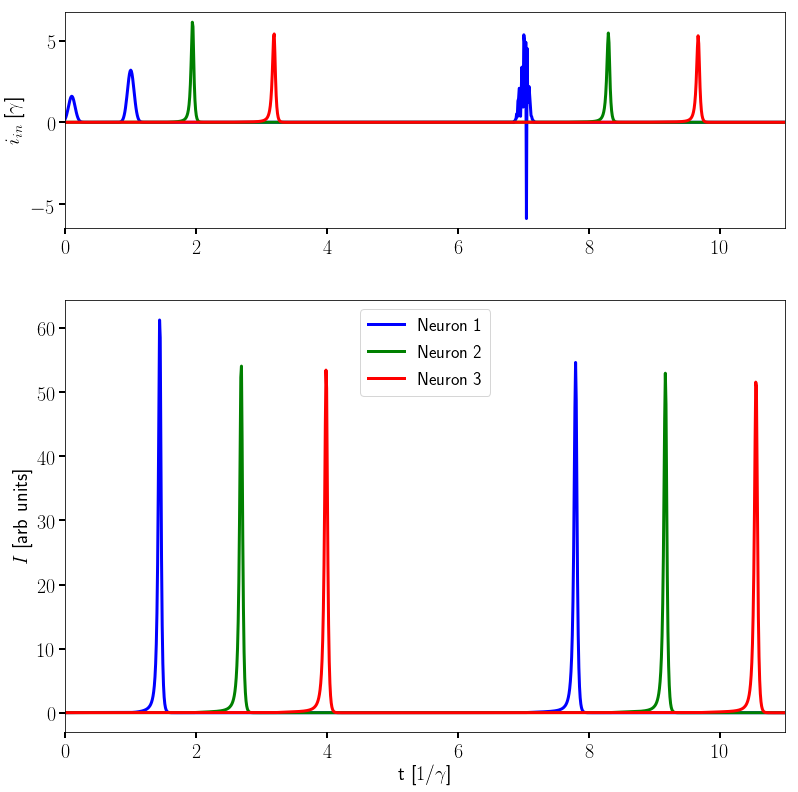

In [20]:
#use visualize_plot to generate a quick plot of the network dynamics
fig1=network1.visualize_plot(input1, output1, time1)

Below is a visualization of the same dynamics as an animated graph.  Each neuron is depicted as a node of the network which brightens when it fires

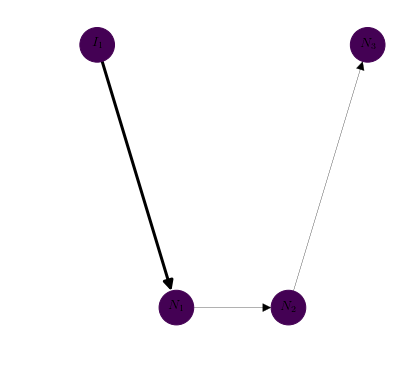

In [22]:
an1 = network1.visualize_animation(inputs=in1, outputs=output1);
HTML(an1.to_html5_video())

We next consider an inhibitory network of two neurons, each with their own input channel.  Neuron 2 is inhbitively connected to neuron 1:  when it fires it prevents Neuron 1 from firing.  

These simple networks often govern reflex behaviours such as the knee-jerk:  When the knee is tapped, the patellar sensory neuron fires, this inhibits a motor neuron controlling the flexor hamstring muscle, causing it to relax and allowing your leg to kick out.

As above, we construct the neurons, as well as the weight and delay matrix, and use these to create a network.  The input signal is a constant drive above threshold to neuron 1, and a rectangular pulse to neuron 2.  Neuron 1 will fire continuously while neuron 2 is resting, but will not fire due to the inhibitory coupling for the duration of neuron 2s activation.

In [7]:
# Inhibitory 2 input 2 neuron network
#neuron 1 is regularly firing, neuron 2 stops neuron 1 from firing 

neurons2=[Neuron(Y1params), Neuron(Y1params)]
weights2=np.array([[1.,0.,0., -0.2],[0.,1.,0., 0.]]) #Neuron 1 receieves input,feeds to neuron 2
delays2=np.array([[0., 0.5], [0., 0.]])
#create network
network2=Network(neurons2, weights2, delays2, dt=0.001)

t2_end=29./Y1mpars["gamma1"]; #atleast this long
N2=int(np.ceil(t2_end/network2.dt)) #this many points
time2=np.linspace(0.,(N2-1)*network2.dt, num=N2 )#data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAx0AAAMYCAYAAACuVIogAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDIuMi4yLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvhp/UCwAAIABJREFUeJzs3XtwZGd95//Po8toZjyXljzG2I7NuCcOGGICmsFASHazjATJkk3qZyScX1K/XyUpRk2KVLYqG0YRVcluUuxONJBkf6nNRXISQvLHJkgOmyIhISOzwLJgwkgsF2Nj47axB99H03PxXHR7fn+cvpzTfbrVl3PpPuf9ooROn77okazR05/n+zzPMdZaAQAAAEBY+uJuAAAAAIBkI3QAAAAACBWhAwAAAECoCB0AAAAAQkXoAAAAABAqQgcAAACAUBE6AAAAAISK0AEAAAAgVIQOAAAAAKEidAAAAAAIFaEDAAAAQKgG4m5A3A4cOGAPHjwYdzMAAACAnrC8vPyStfaGVp6T+tBx8OBBnT59Ou5mAAAAAD3BGPPdVp/D9CoAAAAAoSJ0AAAAAAgVoQMAAABAqAgdAAAAAEJF6AAAAAAQKkIHAAAAgFAROgAAQEPnzkkPPRR3KwD0MkIHAACo69w56eBB6Qd/ULrvvrhbA6BXEToAAEBdH/qQdOGCczw1FW9bAPQuQgcAAKjr7Nm4WwAgCQgdAACgrq2tuFsAIAkIHQAAoC5r424BgCQgdAAAgLqodAAIAqEDAADUtbkZdwsAJAGhAwAA1EWlA0AQYg8dxphZY8yoMSbT4vMyxpjjxphs8Xa2eHssnJYCAJAu1la2ywWATsQeOiSNSlqWdM4YY6s+Hm/wvBFJs5IeN8bY4mvkrbVLEbQZAIBEW1+XDh+WPv3puFsCIAkG4m6ApLykcUmrkgqu82OSTm/z3PHiY0astflwmgcAQPrcd5/01a/G3QoASdENoWPZrzphjJG1dmW7J1trC/KGFQAA0KEnnoi7BQCSJPbpVdba+epzxpgpv/Od8Jm6ZYvTsgAAAACEqBsqHR7GmFFtP62qJGOMmSgej0hatdYuhtMyAADSw5i4WwAgSWKvdPgYa2ZalZw1ICPW2sXix7yke10hxMNaa/w+Am05AAAAgBpdFTqKgaGpBeHW2oLPFKw5OTtaAQAAAOgSXRU6JM1I6mTL27ykbKvX/AAAAAAQnq4JHcWgMFrcjaqZxx/3Ob1a/JwNrGEAAAAAOtI1oUPOdTmaDRxZSbOlq5G7jBQ/c80OAAAAoEt0U+h4k5pfz5GXlPO5IOCYpJVmqyUAAMAfu1cBCFI3hY6sKtOjPIwxGWPM48aYKdfpVXelozg9KyfpWLjNBAAAANCKbrpOR15SowXgI+4b1tpFY8xEccer64vPnfSpfgAAAACIUdeEDmvtdIP7CpKGfc5zIUAAAACgy3XT9CoAAAAACUToAAAAABAqQgcAAKjB7lUAgkToAAAAABAqQgcAAACAUBE6AABADaZXAQgSoQMAAABAqAgdAAAAAEJF6AAAAAAQKkIHAAAAgFAROgAAAACEitABAABqsHsVgCAROgAAAACEitABAAAAIFSEDgAAgDoKVwt69uKzcTcD6HmEDgAAAB/fLXxX3/d736dbf/9WLeWX4m4O0NMIHQAAAD5+9Z9/VS+vv6xNu6nxvxqPuzlATyN0AACAGvV2r3ruuWjbEaenzj8VdxOAxCB0IHXOXz2vP/yXP9SDZx6MuykA0HNuvVX6xCfibkU0dg7sjLsJQGIQOpA6v7706/rlf/xlvf1jb9dzl1I0ZAcAAdjYkD7wgbhbEQ1CBxAcQgdS50+W/0SSdGXjiv7oK38Uc2sAoDs1ujjg449H1444ETqA4BA6kGrPX3o+7iYAQM954xvjbkE0CB1AcAgdSLUXLr8QdxMAoOe86lVxtyAahA4gOIQOpNoLLxM6AKBV1sbdgmjs6Nvhub25tRlTS4DeR+hAqjG9CgBal5bQsb617rl9ce1iTC0Beh+hA6n2/MuEDgBo1dZW3C2IxrXNa57b56+ej6klQO8jdCDV1jfXt38QAKRQo92rUhM6Nryh48K1CzG1BOh9hA6kmmnUqwIAfKVletXa5prnNqEDaB+hA6lmROgAgFalptJRNb2q+jaA5hE6kGpUOgCgdakJHVXTqza2NmJqCdD7CB1IlertDrdsSnpOAAhQWqZXVVc2CB1A+wgdSJXq+bl0IADQurRUOqr7DDYfAdpH6ECqVO+5vrG1IZuWITsAaEGj2adp+bPJ9CogOIQOpEr1qJUkbVquMNu2tLzzAFKo0T/vtFQ6qqdXVQ9cAWgeoQOp4hc6KJe36aMflW64QfrlX467JQBC0ChYpCZ0UOkAAkPoQKr4hQ46kTb94i9KZ89Kf/iH0pkzcbcGQMAaVTrSUuRkTUdI1telv/xL6ZOfTM8vEzQQdwOAKPlWOiiXt+7FF723L12Kpx0AQsP0KnavCs1990nvf79z/IUvSG97W7ztQSSodCBV/Eap6ETa8I1veG+vE9yApGF6FdOrQlMKHJL0oQ/F1w5EitCBVGFNR0C++U3v7bXanyuA3pb26VVbdqumEk5lPAS7d8fdAkQk9ulVxpiMpClJi9bavDEmK2lC0oq1dmmb545KOiIpLykrKb/dc5BurOkIyNNPe29fu+b/OAA9K+3Tq6iMR+Tmm+NuASISe+iQNCJpVtKscTYFL0g61kTgyEqatdaOu84tGGPy1tp8mA1G72JNR0CuXvXeJnQAiZP26VXV6zkkKuOBOHfOe3v//njagch1y/SqcUnDkg5Za4ettYtNPCcnaa7q3JycAAP48gsYjFy1oTpkEDqAxEn79Coq4yF54gnvbabnpka3hA5ZawstVigmJK1UnTtdPA/4Yk1HQKo7CToNIHGYXlXbN1AZD0B1paO6co7E6prQ0YriOpCspFX3eWttoXh/1uc51u8jmhajWzByFRAqHUDipX16Ff1FSOg/Uqsb1nRIUsYYU6pQjEha3WaK1YhUCRk+snIWlwMerOkICJ0GkHhpn17FdNyQ0H+kVjeEjlVJI9ba+dKJ4oJwNQgemVa/iLXW+J0/cuRICv50ooTpVQGp7iSYXgUkDtOrfKZX0V90rrr/YHpVasQ+vaq4lmO+6jQLwhEKtkAMCCNVQOKlfXoVlY6Q0H+kVuyho468pGxx7UZd290PVGN6VUDoNIDES/30KhaSh4P+I7ViDx3GmOM+p0sLxGsWhBeV1muMVL1Wpup+wIOFgQGpnk5FpwEkTuqnV1HpCAfTq1Ir1tBRusCfz25TpTDhGx6KC8jzql3bMSKp1a13kSKs6QgIazqAxEv99CoqHeGg0pFasYaOYjjI+YSEMUkrDXankqQlSUeqzo0WzwO+qHQEhE4DSLzUT6+i0hEO+o/Uin16laRVd6WjOEUqJ+mY+5wx5nFjzJTredOSJqteK1c8D/jy60QYuWoDnQaQeKmfXsXGI+FgelVqxb5lrrV20RgzUbxOx/VypkxN+lQ/RqqeVzDGTBfXhOTlrP+YZWoVGqHSERCmVwGJ1yhYpKHSwXTckDBolVo1ocMYcyLgr3HCWnuh0QO2uRBgaQ3HsM/5FUkrnTUPaUInEhAWkgOJl/pKB9OrwkHoSC2/Sse0pEZrKVqxX9LfSPo/Ab0e0BEqHQGh0wASL/Whg4Xk4WB6VWrVm171dmttx0HBGJOCP0voJVynIyCEDiDx0j69ikpHSOg/UstvIfm8gqt0zItrZqCLsDAwANbWTq9iTQeQOFQ6fCodTMftHKEjtWoqHdba9wX14kG+FhCEtS3WdHTML2DQaQCJk/rQQaUjHH6hw1rJmHjag8g0vWWuMeaeMBsCRIE1HQHwCxiEDiBxUj+9isp4OPz6C6rlqdD0lrnW2r81xhyTszh80Vr7ZGitAkLCmo4A+HUOdBhA4lDpYCF5KOoNXA0NRd8WRKql63RYa++TJGPMu40xY5Ly1trPhNIyIASMXAWASgeQCqkPHfQX4aDSkVrtXpF8SdI5Se8wxnzHGPPHxph7jDH7AmwbEDiu0xEAvw5jnZ8hkDRpn15FfxES+pDUaqnSUVzXca+ca28sWWvvl/TrxfveKOleY8xhORfy+xtr7d8G3F6gI0yvCgAdBpAKqa90sJA8HFQ6Uqvp0GGM+R1J75Z02O8K49bar0r6qqTSFKz9QTUSCAoLyQNAhwGkQupDBxcHDAcDV6nVSqVjStJxv8Dhx1p7vr0mAeGhXB4Av4BBhwEkTtqnV1HpCAmhI7VaXdORgj8zSDI6kQDQYQCpQKWDiwOGgmp5arUSOn5d0nvCaggQBdZ0BIDQAaRC6kMHg1ThoA9JraZDh7V2XtKSMeZEiO0BQsWajgDQYQCpkPrpVWyZGw76kNRqaXqVtfbDkua5Ojl6FZWOANBhAKlApYOF5KGgD0mtmtBhjNk0xryh3hOstU80uxXudq8FRI1KRwDoMIBUIHRQ6Qictf7rN1jTkQp+u1cZSUeNMSMdvnamw+cDgWNhYADoMIBUYHoV/UXg6g1QMXCVCvW2zP1wQK+fgj9L6CVUOgLgV+nY2HDehRgTfXsAhCLtlQ6//mLTbspaK8Pfuvb49R8SoSMl/ELHoSC/gLX2iSBfD+gEazoCUK/T2NiQBgejbQuA0GxXzUj6OEO9vmFja0OD/fytawuhI9VqQgchAUlGpSMAjToNQgeQGNtVMxIfOupMpSJ0dKBe/8EU3VRo9eKAQM/aslvatJs155mj2yJGqoBU2K7SkfQpVn6DVBIDVR2h/0g1QgdSo9GoFVpQb0SKTgNIlGamVyVZvdDBlNwOEDpSjdCB1KADCQidBpAK21UyqHSgZUyvSjVCB1KDDiQghA4gFdI+verapv/fOqbkdoD+I9UIHUgNOpCAMFIFpALTqxioChyhI9UIHUgNOpCA0GkAqZD26VXXNuoMVDElt330H6kWeOgwxrzbGLMv6NcFOkUHEhA6DSAV0j69yj1QtXtwd/mYgaoOUClPtY5DhzHmqDHm48aYXzPGvMFae7+ksQDahog895x06VLcrQife3rVroFd5WOmV7WI3auAVEj79Cp3n3Hd4HXlY0JHBxi0SrUgKh1ZSdOSzks6aYx5TNJ4AK+LCHz0o9JNN0l33SU980zcrQmXu9KxZ8ee8jEdSIvoNIBUSPv0Knel47odldDBQFUH6D9SLYjQkbfWPmGtvc9a+w5r7R3W2l8K4HURskuXpPe/3zl+8knpv/yXWJsTOs+olbsDYXpVa+g0gFRI+/Qq90AVlY6A0H+kWhCh46wx5g0BvA4i9vd/L125Urn9sY8lu1xOBxIQOg0gFdI8vcpaW7/SwUBV+1jTkWpBhI6fkfQZY8ynS+s6AnhNROAb3/DevnRJevrpeNoShbqVDkrlrXF3GtdVfo50GkCypHl61cbWhqycVNVv+jXUP+S5D21y9x87dlSOGbRKhSBCx+PW2hFJ75OzruODxphPB/C6CNlDDzV3Linco1as6eiAO1zsqfwc6TSAZEnz9Cp3fzE0MKSBvoHybQaqOuAOHfQfqRNE6Pi4MebtrnUd77HWvjOA10XI/ALGt74VfTuiUm8hOaXyFtFpAKmQ5ulV7sr4jv4dntDBQFUH6vUfVMpTYWD7hzRmrT0v6TMBtAURWluT8vna8w8/HH1bosL2hwEhdACpkObpVZ5KR/+QBvsHy7fpMzpA/5FqbVU6jDF/4zreZ4w56Lr9bvdtdKdnn/XvMM6cib4tUXFXOtwXetqyW9qyCe49g+befWCf6zqgdBpAoqS60rFRv9JBdbwDhI5Ua3d61a+7jj8oad4Y8xVjzHslnZJz7Q50MXe4GHDVu773vejbEhV3pWOof0iDfYxcteXq1coxoQNILNZ0OIYG6C8C4+4/9u6tHNN/pEJbocNa+4Tr5leste+QcxXyYTlTrbg4YJdzh4u3vKVynJZKBwsDO+CudNBpAImV5ulVjdZ00F90oF6lnDUdqeAbOowxb2/2Bay19xtj7rHWnrfWfthae8RaOxNcExEGd7j4oR+q7FxXKEgvvxxPm8JWU+lgjm576lU66DSAREnz9CrWdITEHToymcox/Ucq1Kt05Fp5EWvt33bSCGPMhDHmuDFmzhhzyhgz0cRzMsXnZIu3s8XbY520JS3coePWW6VbbqncTuoUq4aVDuboNmd9XdrcdI77+6XdlbUxdBpAsrz4YuP7k1zpcIcO1nQEqF7oqHfRQCRKvdAxboz5v4wx++rcH5hiwMhba09aa3OSJiXNGmOmtnnqiKRZSY8bY6yk5eLrLIXb4mRwB4tbbvGGjqROsaoZuWKObuvcHcbOndJQ5YJZdBpAcnzuc9JzzzV+TJJDR80glWHL3EAQOlKtXujISFqUdM4Y85gx5o+2CyEd7FiVtdaulG5YawtywsRcE88dl7OO5JC1dthau9hmG1LnhRcqxzfeKL3ylZXb241u9Srm6AbAPbVq1y5CB5BQ73rX9o9Jy/SqHf07mF4VFHcfQuhInXqhY0nSEUkzkp6Qc7Xx+1UJIX9sjHlvVdCYbvWLG2Myku4tfq7++ipNnWrEWluw1vpccQKNuIPFDTc4HyXuQJIk1SNXdCJtoNIBpEIza/sSXemoWgPIIFVA3H3I/v2VY/qPVKgXOk5Za79anPL0Dmttn6TDkn5J0lcl3StpXs7UprPF63a8p9UvXqxqZBXBFrvGGOv3EfbX7VaNQkcaKh01nQhzdJtDpQNAUZJDR02lg+m4wWB6Var5XpHcWvthn3NflRM45iXJGHO7nOlNY8XP+6uf0wxr7bDP6VFJzVQwMq5F5yOSVplitb2tLens2crtAwdSGDqq9l1n5KpJVDqAxLJW+va3pUOHmn98UrHxSEgIHanW7sUBZa19wlo7b619j7V2RE4gCcqMpBPbPGZV0oi1drH4MS9nqpbvzlfWWuP3EWCbe8a5c5UNiPbtc943vuIVlftTMb2qqtLByFWTqHQAiTUzI915p/SmNzX3+DRVOugvAkLoSLW2Q4eP00G8SHHXqlVr7clGjyuu5ZivOj0nZxE6GqieWuX+XH1/klRXOnb07yjfdncwaIBKB5BYs8Xe82tfa+7xSQ4dVzYqf+t2DezyrAGkMt4BQkeqBRY6rLXv6/Q1igvHc9badq9onpeU9VmYDpe0ho7qLXOHBipvmN2BBA1Q6QBQlOTpVZfXL5ePdw/uptIRFEJHqgVZ6QjCrKSjzTzQGHPc5/Rq8XPoC9N7mV/oSMP0qqsblTfMQwND2jmw0/c+NODuMAgdQGJcvrz9Y6oludLhDh27BnaxkDwI1noHrq67Tuorvg3d2pI2+LkmXdeEDmPMnKRjxR2ttntsVs4FBKvDxUjxM1voNuAXOq6/XjLFFS6rq8n8t+/uRK4bvE5D/a5KxwZvmJvC9CogkV56qfXnJDl0XFmv/K2rrnQwHbdN6+uVX5qBAeeDPiRVuiJ0FNdxzLoDhzFmrN51Ooq7WuV8drcak7TSTHBJM7/Q0d8vjYxUzrt3t0qK6nI5lY42ML0KSKR2Qkeaple5+wum47apulIu0YekTOyhw73blDEma4wZNcaMSZoshQpjTMYY83gxnJSsukNJcR1HTtKxqNreq/xCh+SdYpXEdR0vr1WudrV7cDdrOtpBpQNIJCodXgxShYDQkXq+1+mISjEoLNS5u7qKMeK+Ya1dNMZMFEPL9ZIycgUV1FcvdNxwg/Tww85xEtd1eKZX7bjOO3LF9KrmUOkAEonQ4XV5w7WmY3CX+k1/+Taho02EjtSLNXQUp0Fte62M4uNqLiLIhQDb4+5cqkNHSRIrHdUjV+41HXQiTaLSASQS06u8qtd0GNdbFSrjbdoudKyxVibpYg0diEejSoffY5LAWquX16umV/Uzvapl7i1udu8mdAAJ0c46vkRXOqoGqawrYTFI1SYqHalH6EihZtZ0JG161drmmras00OWri7LHN02XLxYOd67lw4DSIh2BpmTXOmo3jK31H9I9Bdte7ky8Kfdu53POyoX6aUPST5CR8pYm85KR3WVQ5J3ITlrOppz6VLleM8eQgeQEO1sk56mSof72hyEjjZVD1pJ9CEpQ+hImYsXKyNau3dXBhukZIeO6g5EEpWOdlDpABKJ0OF1ZcO7psN9bQ76iza5B60IHalE6EiZelWO6ttJDh3XDV4nSazpaAeVDiCR2gkdaZletXtwt4ypLCQndLSJSkfqETpSJq2ho/oaHRKVjrZUj1S5O4yrV513IWbbDekAdBkqHV6eNR2Du2TFQvKOETpSL/aLAyJaaQ0dftOrWNPRBnensWePcyn7/sr+9Vpfj75NADq2uVn/vnvu8T+fltDBxQEDQuhIPUJHyjQKHddfXzk+e7ZxJ9Rrqi8MKHkrHUyvahJzcoFEalTpmJ31P5/k6VXV1+kgdASgetBKov9IGUKHj8cekyYmpF/91eT9G2gUOgYHpeHiJRitlVZXo2tX2Hx3r+LigK2j0wASqVHocBcz3ZJa6djY2tD6llO17TN9Guwb9A5SURlvj9+glXs3G/d1oJBIrOmosroq/diPSc8849x+6SXpL/8y1iYFqlHoKJ07d67yWL/H9KLtdq+i0tGk6oXkktNplH5p3Bd/AtAzGoWOgTrvFJIaOi5eqwyu7NmxR8YYKh1B8Jtedd11lXPu63ggkah0VPmrv6oEjtLtp5+Orz1BayZ0+D2213kWkg/UrumgE2nCxoazWFxyFouXRqjcnYY7lADoGe1UOpI6ver8tfPl4/1D+yVJA30D6jfOD2LTbnqu24EmETpSj9BRZWGh9tz990ffjrA8/3zl2H0F8pKkhg53J5LZmZEkyuWtqq5ylHapotMAeh6VjorzV12hY+f+8jHVjg4ROlKP0OFy8aL0pS/Vnv/nf46+LWFxh45XvrL2/qSGjsLVQvm4FDpY09Eiv/m4UmWalUSnAfQo1nRUuPuLUqVDInR0zG9NIJXyVCF0uJw+XfkjumtX5fyXv5ycMvJzz1WOb7yx9n536HjhhfDbE5VzV86Vj30rHazp2N6FC5Vjd9Cg0wB6XjuhI0kDU25+lXGJ0NExKh2pR+hwefDByvHP/Zw0MuIcr65K3/lOPG0K0taWt5NI0/SqwrXaSgcdSIvc25mV/nFIVDqABGhnetXp0+G0JW5MrwpJodIPa3/x50roSBVCh8vKSuX4zW+W7r67cnt5Ofr2BM197Y3hYe9OpyWJDR0+06tK1+uQpEtrjNBv6+zZyrH7oi50GkDPa3RdpnqVjq98JZy2xM1vIblE6OiItd4+5MAB5zODVqlC6HD51rcqx69/vXTXXf739artplZJ6Qode3dU1iW4t0hEHc2EDqZXAT2pnUrHQw8lZ+qxm6fSUSd0uC8eiCZcuFD5JbvuusqoJ4NWqULoKFpflx59tHL7zjul172ucjsJocO9iJzQ4ey/XnJp7ZJsEnvPINULHYxUAT2vnTUda2vJvDSPZyG5a3pVdZ+BFlAphwgdZY8/Xvmje+utzhond+h46KF42hUkd6XDb+cqybvOI0kLyf1CR39ff/lCgVbWc9Vy+HB3Gu41HXQaQM9rFDr6GrxTcE/TT4p6C8n3De0rH1+4dkFoAaEDInSUuSsZr32t8/k1r6mce+wx6VqPb3DUTKXjxhsrl1948cXGHVEv8QsdElOsWuJeSF6v0sH0KqAntfu3Pumhwz29au+Qq79Yo79oyUsvVY5L6zkkpuemDKGjyC907NkjHTzoHG9uOsGjlzUTOgYGKlOsrPU+p1etba7p8vplSVKf6fOUyOlEWsBIFZBY7YaO8+e3f0yveely5Q3y8K7h8vG+HVQ62kb/ARE6yvxCR/Vxr0+xamZ6lSTddFPl+Nlnw2tPVF58ubI45fpd18uUSjmi0tESOg0gsah0VDx/qTLadtOeSofI9KoO0H9AhI6yeqEjSYvJm6l0SMkLHc9eqnwTN++92XOfu+pBpWMb7p0FmF4FJIo7dNxzT/PPS2LoeO5SZYTuxj2VzpLQ0QH39Cp3/7FzZ2VO99qas6sPEovQIWfq1COPVG7feWflOEmLydMaOp65+Ez5+Ka9N3nu80yvotLR2JkzlePv+77KMaED6Hnu63QMDjb/vKSFjvXNdZ294ozK95k+3bC7sqUjoaMD7v7jZtfgnzGVCwVKyZyvhzJCh6QnnqgsEn/lK50L55W4qx4PPxxtu4KW1ulVz16sfBPuUrlUNb2KSkd9Fy44H5Kzv7p7pCpTWZjvWWwOoGe4Kx1pDh0vvFzZtvGG3Teov6+yXzChowNPP105vvVW733u/sQ9DQuJQ+hQ/alVkncHq0cfdap/vWhtrbIFrjHerXGr3XJL5dj9d6JXuadXNQwdVDrqq65yuNbFeHYiocMAepI7dNS7GKCfpIUO99SqV+7xjs65K+OEjhYROiBCh6TGoWPvXum225zjjQ3pO9+Jrl1BOnOmcuXYm2+Wduyo/9hXvapy/NRT4bYrCp5KR6PpVVQ66qs3tUrydhjuebsAegaVDke99RwSlY62Wds4dLiv+0S1PNEIHZK++c3KcXXoqD7Xq4vJ3eGhFKLqcd//3e+G054oPXPJtaajqtLh7kTOX2UuaV3u0FHdYezZU3mXcuVKMi9RDCRcu6HjYsLGar57vtLp3bL3Fs997v6CQaoWrK5W+oU9e7xrOCQqHSlC6JD09a9Xjl//+tr7kxY63JUMP9WVjlKFpFd9Z7VSnsoOZz33uRcJvnj5RaGOfL5yXB06jKHTAHpcu6EjabucuvuL7x/5fs997tDhvuAstvHkk5XjW2/1Ts+V6D9SJPWhw1rvAvG77qp9TBJCh7tisV2lY9++ykDE1avenVJ7zcbWhh5ffbx8+47r7/Dc7y6fu8vqqOL+R+Je6FTiXtfBFCug57S7puPy5eDbEqfHVitXAa4OHQd2V/7OuRecYxvurT/9+g936GB6VaKlPnRcuVL5Y3v77c4b7mpJuECge6Bhu9BR/Zgnngi8OZH5buG7Wt9y9v2+ee/NnutySNKN11VCx/MvJ+Dy62FptPBJYqQK6HGtVDp27qwcJ63S8djgF4gaAAAgAElEQVTZSui4Y8Q7SHX9rus12Of8cC5cu6DL6wlLXGFxv3FyX4eghP4jNQgdrunnP/RD/o9xv8f69rcr2+v2kkcfrRzfcUf9x/k95rHH6j+u23377LfLx6++/tU197srHe6r0MJlbc37S7DdSBWVDqDntBI6knoR6bXNNeXPVaaSHho55LnfGOPZ0cq9SQkacA9abRc66D8SjdDRROjYv186VPzbs77uXXjeK75dee+tV9e+967hfoz7ub1m+Znl8vGdB+6suZ9KRxO+/vXKlcMOHvReDLDkhsraGM8FYQB0PWtbuzigO3QkaXrVN57/RrkyfjBz0LOGo8S9A6J7O3bUYa20slK57Rc63BcHS8I+/agr9aHD/QfTbxF5yeho5dj976cXnDtXWZexa1ftOmA/SQkdD37vwfLxW77vLTX37xvap6H+IUnS5fXLurTGFbVr/K//VTn+4R/2f8ztt1eOe3k+HpBCW1uV474+56OR3bsrx0mqdPzL9/6lfHz3LXf7Psa9AyLrAJuQz0vPFHeQ3LfPf3quu/9wzwVH4hA6XKGjXqVD8oaOf/mX+o/rRo88Ujm+447tOxTJGzp69Ursm1ubevBM49BBubwJn/985fhHf9T/Me5Ow73TFYCuV72IvHpzoWpJnV71xTNfLB+/+ZY3+z6G/qJFn/tc5fhHfkTq7699zC23VHYveP75ZJXP4JH60FEqKR84IGWz9R/31rdWjr/whXDbFLTlygwj/eAPNvec17620vE8/HBv/g340pkvafWKsxPGjdfdWLMTScnBzMHysXvnEsh5R/HpT1du/9iP+T/O/Y+HSgfQU6pDx7/7d5Xb7gG3kiROr9rY2tCnHvtU+faP3uY/wHLz3pvLx0+dT8DVc8P2iU9Ujuv1H/39ybtAGHylPnSU/MiPNB7dufvuyjzXRx7prW1kT5+uHL/pTc09Z9++SrVjc1P62teCb1fYFh5aKB//9Kt/WqbOf2D3Wo+HX+zRsk5Y/sf/qCx8et3r/BeRS97Qkc/3/sVdgBSpDh133SX9+Z9Lx45JCwu1j9+xozJgvbHh7DXR6z775GfLg1Q3771Zh28+7Ps494YkD73Yo9tZRuWFF7yDVu9+d/3HHjxYOaZanliEjqJ6s0ZKdu3yvmFfWgq3PUFyTwc7cqT557kf22tTyi5cu6C/+NpflG9PvHai7mPvvMEVOl4idJRtbUkf/nDl9s/8TP3HDg9LmYxzfPky1Q6gh7hDRylM/MIvSPPz/jMAjEneFKs/+PIflI/vec096jP+b4/uurFyMa9vvPCN0NvV0/7rf3V235GkN7+58XQS95zur3413HYhNl0ROowxo8aYKWPMWOlzmM/z82//7faP+YmfqBz/3d+1+5WideZMZU3G4KD0xjc2/1z3lLJTp4JtV9j+02f/ky5cuyDJGZk6mj1a97HuSsfXn/963celzn/7b5US165d0vveV/+xxjjlwJIvfrH+YwF0lYsXK8fNXhjQHTp6dd1fyWee+Iw++egny7fff/f76z72jpE7ytfqOHPhDFcmr+eb35R+93crt//Df2j8+De71tA8+GD9x6GnxR46jDFZSbPW2nlr7ZK1dl5Srng+8Of5ueOO5raR/amfqhx/8pPS+fOtfqXofaoyRVX/+l97O4rt/PiPV44/85nembv7F//nL/T7D/5++fZv/KvfqDtqJUlvvOmNMnKmXi0/u1wusafan/2Zt5P4tV/zXnXcz9veVjnutYVPQAptbko/+ZPefSCaDR3u9cBve5uz6+lHPxps+6Lw8IsP62fv/9ny7Xtfd69ec6DONFJJg/2Det0rKtu+fu7Jz9V9bGotLztvIErz7o4cke65p/Fz3uLa6OVLX/KW35AYsYcOSTlJc1Xn5iTNhvS8Gj/1U9vv1iE581xLC7EvX5buu6/VrxS9P/uzyvG73tXac7NZ6c5iEeDKFemv/zq4doWh1Hn8wt/9QvncOw+9Uz971882eJZ0YPcBvekWZ+7clt3yLCZMlc1NJ12+613Se99b+aP/xjdKH/zg9s93z1G8//7evIomkCKf+pT0D//gPdfsYNqZM97bzz0nfeADvbOc6+zls/rQ5z+ku//07vI1mq7fdb1+9x2/u80zpZ/4/sq0h0888okGj0wRa50rj//Krzhbq3/ve875665z0qjfrlVuP/AD0iuLO4Otrkr//M/hthexMDbmvxDGmMcljVtr865zGUnnrLV1o0C7z6t2111H7Kc+dbqpa1dI0p/8ifRLv+Qc79/vLNL+fv9NkWJ3//3SRHEpw9CQc80d9zXcmvGRjzgdieSs8/ra15xF5nFa31zXi5dfVP5cXo+89Ii+9tzX9JknP6Nvvfgtz+PuesVd+uzPf1Yju0a2fc0Pff5D+o3/+RuSpNfe8FqdPnZauwZ3hdL+2GxuSoWC8wf93Dnnyq9PPuks2vv616Uvf1m6cMH7nNe/3nlncsstzb3+7bdXLu40OysdPx74twGgc88+6/xz9Rsb8Htb4B6Ye8c76r8n/M3flH7rt4JpYxC27Jaeu/Scnjj3hJ4oPKFvvvBNfenMl/TFp7+oja3KaPp1g9fpH3/uH/Wjr9pmgaec63m8+U+d6UA7+nfoa+/7WsPqSCJsbjqJ9Ny5Sh/y1FPO+r1HHnGmRJWux1Gyf7/zRuRo/enNHh/4gPOmQ3IW0X7+89LOncF+HwiMMWbZWtvCSuGYQ0cpJEgattYWqu6zkg65Q0Wnz/Pzmpuut/M//05JkvtnYaxk5f3ZWEl20+qf/km6eMm5b8egdOttzhvxwQGrPlN5rPNCkqn5GdviXVbWuh5bPrbSluvY85hiq2z5Zvm283rO/ZcuSme+56wFNtbqVa9yKjWeVnjaZavvlOSsAfvc56T14t/mPbutbrxR2rnTqn9A8qa7Or9L1d+/sa5PVT9ja7WpdW1urWlT69qwa9qw69qw13Rt62Vd27qkNXu15kuYqi9xcOcbNHrdT2pH3y6fr196TuX8ta2X9ferv6sN6yx629OX0c1Dr9auvr0aMDtlyv9zXsBUfee1/43d31TtKWPUcEiwb2tL/ZsbGtjYUP/mpvo3N13HGxrYcD73F88NbG66jjfUv7HpOnbOD7WwxcyWMfrSD79NH7/3/9ba0FDDx7r/nbzj0/+ke/72/vLth++8U0++6qBe3rNH14aGZGWcn78xskaypk/W+P+M/L9Yowc2/7fMf1Sihb+FddvR3GvUGxUxtvqvzjav02E7Wn/dVr6Wz3nXqWaqy9pq5b+p/2P9zhpr6/9HqHmBANpQ529ASz/nQPpq5zWuXJG+UVwD7ddm95a5JZ/8ZKW9N7xCOntW2tqsfZwkHbjBmY25Y6A4Xcvzs/b/Pqr/hjdi7ZY27brTV9h1bdqN8u11e1VrW1e0Zq9obeuKNuzVbf817Ou/QW/de69GBm7a5pGlr2/1wPk5nV13Blh2mJ26Zced2tN/vXaYnTKmT95+wjlqejS0hZ+FkVXfptNflPqK/s3NYh+yWXO+9sP//r6tTfW7XnewxelOj2cP6S//31/U869s7mcqSQdeeE7/8bd/s/y1nr/hFfrWa39QheGMruzcpa2+PqfvkGT7+pzPTf0hCU9rfys7U/2V6v29icrP/9XHei50ZCU97leZKIaHcWttzT5R7TyveL7GYUmn/e4AUuh7e6W/vVP64yPSw69o/fmDG9IX/ly6+5ntHwsASI6LO6RP3SF99A3Sp79fLaSsil/739KHe2zjmrQyUsuho8klY6HJRPw8ILW2JJ3fKZ3bKa3uks7tkp7aL+WHpe+MSF++RfpuRm11FCXrA9I7/h/pvk9Kk9/a/vEAgN5wfsjbfzy7x+k/8sPSyk3SQ6+QtjpcKfyRH5auDkgf+oy0n2WBiRN36IhMvXUer9m/y37+h11bd7jfcfk8w8iZFuK8qNGll51S9caGM+XRNpy4UXtf6fHuCqFz7N8O436wqZx1NUmS0eCAtGeP82FMpSxXc4G8RqXJqvs2NowunJcuXXa+360tU1Pvq1fqrP9zqZmoJGMH1GcHJQ2qzxY/NKj+rd3qt7vVZ3fJ+O6BUP97KX392nJX7XO2zJpeHvyurg68qE1zRVt914rPteX/l3E+u59d73v0/7qNn2ON0Vp/n9b7+rTe36f1/n6t9xmt9/Vro3h+rb9PG33OfWt9pePSY13PLX6+1t/vlKd9Of8dDra7+2PVP6/jY9L/d/dF3f2953Tb+Yvat7amXesbMrLlaRSl4z5rWyqRN67N+vwbqz7VaCZc9b+9tvj9O29evb8VdR9ff+VbC1+1zus2uTyulTa0WlsP5nej0/8mLfwsm2mv64s3vwKxtXZs+3OzTv9w4IDUP2i0tiZduSzt2+//LSwvF59mncf8wB01L6fHv+MsC9u9W9qzt9gvbrXy36+5xzp/rZx+wtgB9WlAxjof/XZIfXan+osffVtDktlmEXPVq7diS1ZXBp/RlYHvadNc1mbfVancV3inMIf133qjz2ij2AeUjtf7+rRR6iNc99We7/c8f718n/fcel9fg/7DcduFhnc3xcjoH14t/c/b13X4mRf02hfPKnP1mvasrctYqz45U5qMnL7DmZIa7xSr5uaKhiPWCVbfeqzlp3RF6DDGZKrXZoT5PLc9d7xO/+ofmWAFAEA9b3e9r3rnO6V/WvR5jJyg0ey2uwB6WBthK+4tc0uLvT3bCxUXirvvD+p5AAAgJAQOAPXEGjqKVYq8atdojEgq1NuBqt3nAQAAAIhe3JUOSVqSVL36fbR4PoznAQCANsW8SymAHtUNoWNa0mTVuVzxvCRn2pQx5nFjzFQrzwMAAAAQv9hnX1prC8aYaWPMcTlTprKSZn2mSI20+TwAAAAAMYo9dEiStXZF0kqD+wuShlt9HgAACBbTqwC0oxumVwEAAABIMEIHAAAAgFAROgAAAACEitABAACaxpoOAO0gdAAAAAAIFaEDAAAAQKgIHQAAAABCRegAAAAAECpCBwAAAIBQEToAAEDT2L0KQDsIHQAAoGmEDgDtIHQAAAAACBWhAwAAAECoCB0AAKChoaHK8RvfGF87APQuQgcAAGjos5+Vbr5ZevObpZmZuFsDoBcNxN0AAADQ3d7yFunpp6U+hioBtIk/HwAAYFsEDgCd4E8IAAAAgFAROgAAAACEitABAAAAIFSEDgAAAAChInQAAAAACBWhAwAAAECoUn2dDmOMLX5ejrstiN3h4md+F8DvAkr4XUAJvwso4XfB8apWn2CstWE0pCeUQoe11sTdFsSL3wWU8LuAEn4XUMLvAkr4XWgf06sAAAAAhIrQAQAAACBUhA4AAAAAoSJ0AAAAAAhVqheSAwAAAAgflQ4AAAAAoSJ0AAAAAAgVoQMAAABAqAgdAAAAAEJF6AAAAAAQqoG4GxAXY8yopCOS8pKykvLW2qV4W4U4GGMm5PwOHCp+nrPWLsbbKsTNGJORNGutzcXdFsSj2E+MFW9eL+dvQz7GJiEGxpgxSaPFm9dLetxaOx9jkxCR4vuDgt/7Q95Hti6VocMYk5XzZmLcdW7BGJOnQ0mX4h+UfClkFN9oLhtjRuhUUm9W0kjcjUA8in8bxt2h0xgzK2k6vlYhasU3lrLWnnSdmzDGTNFHJFsxbN4nadLnPt5HtiGt06tykuaqzs3JeZOBdMlaa1dKN6y1BTm/B9W/H0iRYodC4EgpvypXMYRMxNcqxCRXPXpdHKQar/N49DhjTNYYMyenerFa52G8j2xDWkPHhKSVqnOnRYeSKsU3FvcWP7stFe/PRt8qdIkxSafibgRiMyPJM8WSN5qpdaROX1DdbyAhrLV5a21um0oW7yPbkLrQUXyDWZNeiyPcvNFMkeJ/82zxA5BULql/PO52IFZTkr5SfZJpE6m0JOlUaZqVVK56LcTXJMSJ95HtS+OajhGp8svhIytnURBSwFo77HN6VM7CMX4P0iljrS0YY+JuB+KTkZQ3xkzJ9caCDSbSx1o7XRyIWDbGTKv4/oD1HKnG+8g2pTF0UBLFdmYknYi7EYieMWaCN5bp5hqlzLrfWBpjZtlgIp2stYeNMafkzNdfkXQ05iYhXryPbFPqplcBjZRGNt07lSAdiiXzeiNXSI96byj+RiwSTaViv5CTs6YnK6fqwRQaoEWpDR0+i4eRcsVOJOfeAg+p8h72WIcq0yI80yOKu9xleLOZLsVdjJaKi4uXJN0u53eDjSZSjveRrUtj6Ch1JJ7tMF2/PMzDS69ZUTZPpeIi0dNxtwPxc83TbjRfGylQel/gXt9nrS0UB6YKxbUeSB/eR7YpdWs6igtE86otoY+IxcOpVRzNOtZgYRiS7YikQ8aYe13nRiVlixeE+wprPVKlfIXhOvchHY5IWq5z35yY259KvI9sX+pCR9GSnD8m7j2WR4vnkTLF+bqz7sBRHMHiyqIp4bc42BhzXNKbrLVcgTp95lTVJxSrYfxNSJe8fK5GXZQR7xnSjPeRbUjj9CpJmlbtH5Jc8TxSpLjfeuk4a4wZLQaOSd5cpN71cTcAsZmX0ye4zfqcQ4KV+oDqaVTFdT3X00ekwoj8K1q8j2yDsdbG3YZYFEetxlQpo6+wiDRdivMvz9W5O2+tPRRle9Adim8opiW9R05nMy9prriQGClR2lhC0llJhyQt0EekU7EafkjO74LkTKFh6+SEKr43mJHz3nBCzvvEJUmn3NNseR/ZutSGDgAAAADRSOv0KgAAAAARIXQAAAAACBWhAwAAAECoCB0AAAAAQkXoAAAAABAqQgcAAACAUBE6AAAAAISK0AEAAAAgVIQOAAAAAKEidAAAAAAIFaEDAAAAQKgIHQAAAABCRegAAAAAECpCBwAAAIBQEToAAAAAhIrQAQAAACBUhA4AAAAAoSJ0AAAAAAgVoQMAAABAqAgdAAAAAEJF6AAAAAAQKkIHAAAAgFAROgAAAACEitABAAAAIFSEDgAAAAChInQAAAAACBWhAwAAAECoCB0AAAAAQkXoAAAAABAqQgcAAACAUBE6AAAAAISK0AEAAAAgVIQOAAAAAKEidAAAAAAIFaEDAAAAQKgIHQAAAABCRegAAAAAECpCBwAAAIBQEToAAAAAhIrQAQAAACBUhA4AAAAAoSJ0AAAAAAgVoQMAAABAqAgdAAAAAEJF6AAAAAAQqoG4GxC3AwcO2IMHD8bdDAAAAKAnLC8vv2StvaGV56Q+dBw8eFCnT5+OuxkAAABATzDGfLfV5zC9CgAAAECoCB0AAAAAQkXoAAAAABAqQgcAAACAUBE6AAAAAISK0AEAAAAgVIQOAAAAAKFK/XU6AKBbXbt2Taurq7p48aI2Nzfjbg4itGPHDh04cED79++PuykAEAhCBwB0oWvXrumpp57S8PCwDh48qMHBQRlj4m4WImCt1ZUrV3TmzBkNDQ1p586dcTcJADrG9CoA6EKrq6saHh7WgQMHtGPHDgJHihhjtHv3bh04cEAvvvhi3M0BgEAQOgCgC128eFH79u2LuxmI0d69e3X16tW4mwEAgSB0AEAX2tzc1ODgYNzNQIwGBga0sbERdzMAIBCEDgDoUkypSjf++wNIEkIHAAAAgFAROgAAAACEitABAAAAIFSEDgBAbObn52WMkTFGhULBc1+hUJAxRktLSzG1Lli5XK7me0Rjjz4qffSj0oULcbcEQKcIHQCA2GUyGc3Pz8fdjFDk83lNT08n9vsLy5Ur0lvfKv3iL0q/8itxtwZApwgdAIDYTU1N6cSJE3E3I3AnT57UoUOHtLi4GHdTes7f/720uuocf+xj8bYFQOcIHQCA2JWmHiXtzfnx48dlrdXc3FzcTek57BgMJAuhAwAQu2w2q4mJiURWO9Ce/v64WwAgSIQOAOgxxnTvRydmZma0srKilZWVho+bnp7W8PCwhoeHNT09XT4/OTmpycnJqp+V8VRPJicnlcvltLS0pPHxcZ08ebJ8X2kq1PDwsCYnJz2Lvkuv7X6M+7kIHqEDSBZCBwCgK4yOjmp0dLRhtWNyclKLi4taWFjQwsKCFhcXW16gvbS0VA4RU1NTkpzpXXNzc5qbm9Py8rJGRkZ0++23e4JHKbycOnVKU1NTmp6eVj6fb+M7RTMIHUCyEDoAAF1jZmZGi4uLvlvL5vP5cuAYGxvT2NiYZmdnW14vkc/ntby8rKmpKWUyGeXzec3Pz+vUqVMaGxtTNpvV3Nycstmsp5KSyWR0/PhxZbNZzczMlF8L4SB0AMkyEHcDAACtsTbuFoRnYmJCmUxGJ06cKL+xLyldr+Pw4cMdfY3R0VFls1nP62YyGc85SRobG/NMzTpy5Ej5OJPJSBLX3QhRH8OiQKLwTxoA0FVmZmY0Pz+v1dJ+qS6ZTEbW2pqPVlSHi2aVggaiQaUDSBZCBwCgq0xNTalQKNRMmxobG1OhUGi40NxdeWi2CnHkyBHf111aWtLY2FgLLUeQqisdSa7wAWlA6ECkLlyQ/v2/lz7wAenq1bhbA6AbZTIZTU1N1SwQz2azmpqa0uTkpJaWlsprPMbHxyVJIyMjyufz5Y9jx4419fVGR0c1MTFRft2VlRVNTk4qn89rdnY2kO+pFID8qjfwVx0yNjbiaQeAYBA6EKkTJ6Q/+APpIx+Rfu/34m4NgG41PT3tW6mYm5tTLpdTLpfToUOHdOLECeVyOUnODlSrq6s6dOiQcrlczZqQRhYWFjQxMaFcLqejR4+qUChoeXm54ylV8/PzMsaUt/I9dOiQjDHbbgsMaWvLe3t9PZ52AAiGaXUubNIcOXLEnj59Ou5mpIZ7H/+dO6UrV+JrC9DNHn74Yd15551xNwMxS/Pvwac/Lf34j1duFwrS/v3xtQdAhTFm2Vp7ZPtHVlDpQGyuXYu7BQCAblVd6Vhbi6cdAILR9VvmGmNGJZVW8l0vac5am6+6/4ikvKSspLy1dinyhqIpg4OVEnnKi2wAgAaYXgUkS1eHDmPMhKRxa23OdW5W0nTxOCtp1lo77rp/wRiTdwcTdI+hIToOAMD2Nje9t+k7gN7WtdOrjDEZOYHCHTgmJE24HpaTVH0p2jlJwWw3gsDt3Bl3CwAAvYBKB5AsXRs6JM1IWnSfsNYuShp3nZqQVL0FyGl5gwm6CKEDANAMQgeQLN0cOqYkfaX6ZGnaVLESkpW0WnV/oXh/e5ecRaiGhuJuAQCgFzC9CkiWbg4dGUl5Y8yUMWai9OG6f0SqhAwfntBhjLF+HyG1HXVQ6QAANINKB5AsXbmQ3FWlyFpr513nZ40xI8VznV2xCbEgdAAAmkHoAJKlWysd9QLF36jNReLWWuP30X4T0Q5CBwCgGUyvApKlW0NHvuqzJMlauyIp416vUVzbgR7Bmg4AQDOodADJ0pWhw7VOo9F6jVIgGXHf4QohXKejC1HpAAA0g9ABJEtXho6i0hXGfe8rBpO8aqdijUgqcHHA7kToAAA0g+lVQLJ0c+iYkzTqPmGMGZUTOEqBYknSkarnjRbPowtVT6+y7B8GAPBBpQNIlm4OHfNyrjjuNlt1blrSZNVjcsXz6EKmaun+tWvxtANAd5ifn5cxRsYYFQreGbWFQkHGGC0t9fY4Ui6X0/DwsIaHh5XLVXdrqKc6dKytxdMOAMHoyi1zJWddhzFm3BgzK+mspEOSZq21S1WPmTbGHFdlOtYsU6u6V3UncvkyU64ASJlMRvPz8zp+/HjcTQnU5KQzLvbAAw8on8/r2LFjyufzOnXqVMwt635MrwKSpWtDh1S++njDqkVxR6uVaFqETvmFjpER/8cCSI+pqSmdOHEiUaGjUChoaWlJ586dkySNjo4qm83q8OHDWlpa0tjYWMwt7G5MrwKSpZunVyGB6EQA+MnlcioUClpcXIy7KYGampry3B4ddZYqrqwwVrYd+gsgWQgdiFR1J8JCcgCSlM1mNTExoRMnTsTdlMBkMhnNztZezzaT4fJSzWB6FZAsXT29CslTHTqqbwPYnvkts/2DYmL/Y/sjCTMzMzp8+LBWVlbKFQE/09PTmp+fl+RUEkpv7EvrJxYWFsqPNcZoYWFBExMT5ceMjIxocnJSs7OzGh8fL0/pOnnypObm5rS6uqqxsTHdd9995YBQeu03velN5cfMzMy0PB0sn8+rUCgwtaoJVDqAZKHSgUhR6QBQz+joqEZHRxtWOyYnJ7W4uKiFhQUtLCxocXGxHECatbS0pMnJSU1OTpanP+VyOc3NzWlubk7Ly8saGRnR7bff7tlRqzT169SpU5qamtL09LTy+db2LZmentbY2FjDUAUHoQNIFkIHIkWlA0AjMzMzWlxcrNk+V3KqBKXAMTY2prGxMc3Ozmpubq6lr5HP57W8vKypqSllMhnl83nNz8/r1KlTGhsbUzab1dzcnLLZrKanK3uZZDIZHT9+XNlsVjMzM+XXatbJkye1srLiqcSgPqZXAcnC9CpEikoH0LlOpjB1u4mJCWUyGZ04caL8xr6kdL2Ow4cPd/Q1SrtIuV83k8l4zknS2NiYZ2H7kSOVa9GWpl35hSM/S0tLOnHihJaXl1nT0aTq/mJjI552AAgGlQ5EikoHgO3MzMxofn5eq6urNfdlMhlZa2s+WlEdLprVbljI5/OanJzU8vJy2187jRikApKF0IFIEToAbGdqakqFQqFm2tTY2JgKhULD7WbdlYdmqxBHjhzxfd0grqVRKBQ0Pj6uBx54gMDRourpVYQOoLcROhApRq4AbCeTyWhqaqpmgXg2m9XU1JQmJye1tLRUXuMxPj4uSRoZGVE+ny9/HDt2rKmvNzo6qomJifLrrqysaHJyUvl83nfL21YcPXq0vHPWyspK+aPVBehpxCAVkCyEDkSKTgRAM6anp30rFXNzc8rlcsrlcjp06JBOnDihXC4nydmBanV1VYcOHVIul6tZE9JIaVvdXC6nowTcBH0AACAASURBVEePqlAodLz+Ip/Pa2VlRSdPntThw4c9H60ufk+j6koH/QXQ20yrc2GT5siRI/b06dNxNyM1/s2/kT772crtr35VesMbYmsO0LUefvhh3XnnnXE3AzFL8+/BBz8ouXdP/uAHpf/8n+NrD4AKY8yytfbI9o+soNKBSFHpAAA0g/4CSBZCByLFmg4AQDNYSA4kC6EDkWLkCgDQDPoLIFkIHYgUnQgAoBlUxoFkIXQgUnQiAIBmsHsVkCyEDkSKSgcAoBkMUgHJQuhApOhEAADNYJAKSBZCByJFJwIAaAa7VwHJQuhApKh0AACawSAVkCyEDkSKTgQA0AwGqYBkIXQgUoQOAEAz2L0KSBZCByLFyBUAoBn0F0CyEDoQKSodAIBm0F8AyULoQKQYuQLgNj8/L2OMjDEqFAqe+wqFgowxWlpaiql1wZientbw8LCGh4c1OTlZ833CH7tXAclC6ECkGLkC4CeTyWh+fj7uZgRufHxcKysreuCBB7S8vKxCoaCjR4/G3ayeQH8BJAuhA5Gi0hGMR156RG/9s7dqcmFSa5trcTcH6NjU1JROnDgRdzMCl8lktLCwoNHRUWWzWc3OzmplZUX5fD7upnU9QgeQLIQORIpOJBg//dc/rQfPPKjFby1qfjl5o8NIn1wup0KhoMXFxbibEqiFhQVlMpnybcJG85heBSQLoQORotIRjEfPPlo+fuCJB2JsCRCMbDariYmJRFY73E6cOFGueqAxBqmAZCF0IFJ0IsHbN7Qv7iYkR6/8QhrTvR8dmJmZ0crKilZWVho+zr0we3p6unx+cnJSk5OTVT8q46meTE5OKpfLaWlpSePj4zp58mT5vpMnT+rQoUO+C75Lr+1+jPu5jRQKBU1OTmp4eFiS9MADDBQ0g0EqIFkIHYgUoSN4e3fsjbsJyTA1JQ0PS3/6p3G3JLVGR0c1OjrasNoxOTmpxcVFLSwsaGFhQYuLiy0vQF9aWiqHiKmpKUnO9K65uTnNzc1peXlZIyMjuv322z3BoxReTp06pampKU1PTzc9XWpkZERHjhxRoVDQ6dOnW2pvWnFxwPB8/KGPa/YLs7pw7ULcTUGKDMTdAKQLI1fBI3QE4NFHpfvuc46PHZPe+95425NiMzMzdbeVzefzWlxc1PLyskZHRyVJs7OzOnHiRDk8NCOfz+vxxx8vT3HK5/Oan5/3nJubm9Pp06c1PT2tubk5Sc6i8OPHj5fbefLkSeXz+W2nSmUymfJrLC4uanx83PM9wB/9RTi++PQXde/ivZKkc1fP6XfGfifmFiEtqHQgUlQ6grd3iNDRsbNn425Ba6zt3o8OTUxMKJPJ+FY7StfrOHz4cPnaHpOTk9tOx6pWvaZiaWlJmUymJjyMjY15rhFy5MiR8nFpcXir19wofX+lEIL66C/C8duf++3y8ez/no2xJUgbQgcixchV57as94e4Z8eemFqSIDt2xN0CuMzMzGh+fl6rq6s192UyGVlraz5a0e4ibvcuVJ0YGRnx/d7gxe5V4biycSXuJiClCB2IFCNXnbt47aLntlFni3eh2tDBu5tYTU1NqVAo1FQDxsbGVCgUGlY23JWHZqsQpbUW1a+7tLSksbGxFlrutbKyUrMFcKFQUD6f1/j4eNuvmxb0F+G4sk7oQDwIHYgUlY7Onb923nO7uvKBAKxxwcU4ZTIZTU1N1SwQz2azmpqa0uTkpJaWlsprPEpv4EdGRpTP58sfx44da+rrjY6OamJiovy6KysrmpycVD6f1+xs+9NPstmspqeny7tllV639H2gMfqLcFDpiNDWlvSe90ivfrX0xS/G3ZrYEToQKUauOle46h29JXQEoHoexxU65bhNT0/7Virm5uaUy+WUy+V06NAhnThxQrlcTpKzA9Xq6qoOHTqkXC6nmZmZpr/ewsKCJiYmlMvldPToURUKBS0vL3c0pSqTyWh5ebnctqNHj3rOoTF2rwoHlY4I/ff/Li0sOJuVvO1tcbcmduxehUgROjp3/qq30rFpN+s8Ek2rfndz+bIU0Px9NDY1NeU76p/NZuuu1Th+/Hh5Fym30dFRnTt3znOu+jUWFhbqtmV2drZuZcPvec2sJWHRePuodISDSkeE2B7bg0oHIkUn0rmLa941HVQ6AkClA+g6DFKFg0pHhDq8YGrSEDoQKTqRzm1ued8gEzoC4FfpABArdq8KB5WOCPXxNtuNnwYiRaWjc9XTqapDCNpApQPoOgxShePqxtW4m5AeVDo8CB2IFJ1I56orG1Q6AkClA+g6DFKFb6h/KO4mJBuVDg9+GogUnUjnCB0hoNIBdB12rwrfrsFdcTch2ah0eBA6EBm/gEEn0rrq6VTsXhWAjQ3vbSodQOyojIdv1wChI1RUOjz4aSAyfh0GnUjrqHSEoEsrHc1syYrkSvt/fyrj4aPSETJChwc/DUTGL2DQibSuurJB6AhAF67p6O/v1/r6etzNQIw2NjY0MJDey2lR6QgflY6QETo8+GkgMlQ6glEdMti9KgBdWOnYu3evLly4EHczEKOLFy9q586dcTcjNtWDUgxSda66erajf0dMLUkJQodH1w6hGGMykqYkLVpr88aYrKQJSSvW2iXX40YlHZGUl5SVlHffj+5BpSMYTK8KQRdWOkZGRvTUU09Jkvbt26fBwUEZFiWmgrVWV65c0UsvvaTbbrst7ubEhkpH8Kor5VZ0wqHib7ZH14YOSSOSZiXNFjvagqRjVYEjK2nWWjvuOrdgjMlba/NRNxiNUekIBhcHDEEXVjqGhoZ02223aXV1VU8++aQ2q9uIRBsaGtKNN96Y6koHazqCR6U8YlQ6PLo5dEjSuKTTkkbqhIicpLmqc3NywspkyG1Di6h0BKOm02D3qs5Vv6G/di2edlQZGhrSTTfdpJtuuinupgCRo9IRPCrlEauudFib6upH10cwa22hQdViQtJK1bnTxfPoMlQ6gkGnEYLq0EEaBmJHpSN4bLkeseq+JeWbg3R96KinuOYjK2nVfd5aWyjen42jXaiP0BEMdq8KAVchA7pOdcjgn2XnGLSKWPU1oAgdXS1jjJkofkwZY9wVjBGpEjJ8eEKHMcb6fYTVcNRielUwmJMbguqOgXc3QOyodASvetCK/iNk1X3L2lo87egS3bymY1XOWo750oniInFZaxclZeJrGtpBpSMYjFSFgEoH0HVY0xE8+o+IUenw6NpKR3Etx3zV6dIi8XZez/h9dN5SNItKRzDYvSoEhA6g61DpCB4bkUSsum9JeaWja0NHHXlJ2eJ6DknltR3oAVQ6gkGnEQJCB9B1WNMRPAatIsb0Ko+uDR3GmOM+p0uLxrNyAohUXNvhel4phHCdji5DpSMYLCQPAaED6DpUOoLHmsCIMb3KoytDR+mifz47UJUCRr64gDyv2rUdI5IabbOLmFDpCAZzckNA6AC6Dms6gsegVcSodHh0ZegoBoacT3AYk7Ti2rFqSdKRqseMFs+jy1DpCAbTq0JA6AC6DpWO4NF/RIxKh0dXho6iVXelozhtKifpmOsx06q98niueB5dhkpHMJiTGwJCB9B1WNMRPPqPiFHp8OjaLXOttYula3RIul7ONKpJd/XDWlswxkwX13/k5az1mGVqVXcidASD6VUh4DodQNdhelXwWNMRMSodHl0bOiSVrsex3WNWJK1E0Bx0iOlVwaDTCAGVDqDrML0qeAxaRYxKh0c3T69CwlDpCAYLAUNA6AC6DpWO4NVckZw1HeGi0uFB6EBkqHQEg5GqEBA6gK5T3T/QX3SO/iNiXBzQg9CByFDpCAa7j4SA0AF0HSodwauejsv03JAxvcqD0IHIUOkIBruPhIDQAXQd1nQEj0pHxJhe5UHoQGSodASDTiMEhA6g61DpCB6V8ohR6fAgdCAyhI5g1CwEpDzeOUIH0HVY0xE8v5DBwFWI2I7dg9CByDC9KhhUOkJA6AC6DpWO4Pn1F/QhISJ0eBA6EBkqHcEgdISAjgHoKn4DUgxSdc6vMk61PET0LR6EDkSGSkcwWEgeAiodQFdhkCocVDoiRujwIHQgMnQiwWAhYAgIHUBXodIRDr/+gj4kRIQOD0IHIkOlIxhMrwpBdejgFxOIFYNU4aDSETEGtDwIHYgMnUgwqkel6DACQMcAdBUGqcLh11+wpiNEVDo8CB2IDKEjGDXTq+gwOkfoALoK/UU4/PoLBq5CROjwIHQgMoxcBYPpVSEgdABdhTUd4fCtdLCmIzyEDg9CByLDyFUwmF4VAkIH0FXoL8LBxQEjRujwIHQgMlQ6gsHuVSGgYwC6CqEjHKzpiBh9iwehA5GhEwkG1+kIAZUOoKswSBUOdq+KGKHDg9CByNCJBIM1HSEgdABdhUGqcPhekZxqeXgIHR6EDkSGTiQY7F4VAkIH0FVYSB4OKh0Rq+5LqvualCF0IDKEjmCwkDwEhA6gq9BfhMP3iuQMXIWHvsWD0IHIML0qGEyvCgEdA9BV6C/CQaUjYtW/yCnvWwgdiAwjV8Fg96oQEDqArkJ/EQ7WdESMvsWD0IHIMHIVDHavCgEdA9BVWNMRDiodEaPS4UHoQGQYuQoG06tCQOgAugr9RTi4TkfE6Fs8CB2IDJWOYFSXwukwAsBoFNBV6C/CwRXJI+T3C5vyvoXQgcgwchUMKh0hYDQK6Cr0F+HwrXSwpiMcftvjpvyXmNCByDByFQxCRwiodABdhTUd4fCrjNOHhITkXIPQgcjw7y8Y1Z0Go1QBIHQAXYX+Ihys6YgQlY4ahA5Ehk4kGFQ6QkDoALoKlfFwsHtVhHjTU4PQgcjQiQSD0BEC1nQAXaXeP0H6jM74XpGcank4qHTUIHQgMoT+YLB7VQiodABdpV64IHR0hkpHhHjTU4PQgchQ6QgGlY4QEDqArlLvnyD/NDvje0VyBq7CQaWjBqEDkSH0B4PQ8f+3d+9Blpz1ff8/z5mZ3dUuWo1GFxACCWaFuRO0WiAYO3FgF3DKsYOzknxJUvEFLf658K+Cba2VqlQ5VBK8klMu/+JgrxS74l9SZUur2LFxCNYuxjYGYyStMCAwLJoVAknotjt7v82cJ390n+k+fTmnL8/Tp8/2+2VPbU+fPmdaQ/c8/X2+z/d5PCDoAFqFoMMPpsxtEEFHCkEHGkOmww1mr/KAmg6gVajp8IPFARtET2sKQQcaw/3nBpkOD8h0AK2SF1xwa9bDlLkNItORQtCBxhB0uJHsqSLocICgA2gVMh1+UEjeIB56Ugg60BiGV7lBo+EBw6uAVqGmw4/MQnKG6PpBpiOFoAONIeh3g/S4B8kLkWgYmCgyHX5ktR+WX6ofPPSkEHSgMWQ63MgKMKz4RdbC8CqgVajp8INC8gaR6Ugh6EBjCPrdYHiVBwQdQKuQ6fCD9qNBPPSkEHSgMWQ63CA97gE1HUCrUNPhB0FHg8h0pBB0oDEE/W6QHveATAfQKmQ6/GB4boN46Ekh6EBjuP/coKfKA4IOoFWo6fCD9qNBZDpSCDrQGIZXuUGj4QHDq4BWIdPhB5nyBtHTmkLQgcZw/7mRlR6n0aiJTAfQKtR0+EGnVYPIdKQQdKAxZDrcyCwkZ0xuPQQdQKuQ6fCDTqsG0dOaQtCBxnD/uUF63AOCDqBVqOnwg9kPG0SmI4WgA40h0+EG6XEPqOkAWoVMhx+0Hw2ipzVldtInUJQxZl7SHmvtrsT+rZK2SVqStChpyVp7YAKniDG4/9yg0XAs6ynG2uDLmObPBwA1HZ6QKW8QmY6UqQk6JO2RtBDfYYxZVBCI7Ijt22eMWbLWLjV9ghiNoMONzHnW6f6rblSXKkEHMBEEHX7QadUgHnpSpmJ4VRhcLGS8tEvS3sS+vQoCFLQMw6vcoNFwjKcboHUYXuUHmY4GkelImYqgQ9J2Sfsz9u+UdDCx76FwP1qG+88Ngg7Hsi5MiYsTmCAKyf2g/WgQmY6U1gcdxpjtku7L2D+voIbjSHy/tXY5fH0xcbzN+vJ46kgg0+EGPVWOkekAWodMhx9Mud4gelpTWh90SJofBBIJC1IUZGRYzNmPCSHory+vdoOgowaCDqB1uC39YJ2OBvHQk9LqoMMYs9Nae3/Oy/NlPstaa7K+HJwmCiLTUV9e40BPVQ0MrwJah0yHHwyvahCZjpTWBh3h8Km8LAamEEF/fVlDqyQajVroUgVah5oOPxie2yAeelJaG3RIuqXIehthcIIpQKajvrzGgUajBoIOoHXIdPhBpqNBWZmOvMx6R7Qy6AgX/HtozGGDdTiSa3fMJ15HSxD015c1Hlei0aiFoANoHW5LP6jpaBAPPSltXRxwm6QtxphbY/u2Slo0xuyR9KC19n5jzJLStR0LkpZZHLB9uP/qI9PhATUdQOuQ6fAjc/Yqfql+UNOR0sqgw1p7d3KfMeZ2SW+x1u6O7T6gIECJr9WxNdyPlmF4VX25heT8IqujSxVoHWo6/GB4VYPoaU0pHXQYYz7i+Bw+Yq09XuC4KzL27Za0T1I8SNkVfqFluP/qo5DcA4IOoHXIdPhBIXmDyHSkVMl07Ja7WaUuk3SvpC/kHRAu8rdb0i2S5o0xeyXttdYetNYuG2N2h1mQJQVrc+xhaFU7kemoj+FVHjC8Cmgd+gL8INPRIIKOlKrDq95prc0NFIoyxoz97YcBRG72wlp7UMPDq9BSZDrqI+jwgKcboHXIdPhBIXmDeOhJqTJ71d1yl+m4W8wy1RlkOurLm72KxQFrIOgAWoeaDj8yC8lpP/wg05FSOtNhrf1A1n5jzCskzcczIMaYX5D0FkkPWGt/u+hn4eJE0F8fmQ4P6FIFWofb0g+GVzWIh54Ul+t07FVsCJQx5gFJeyRtkXS3MeY/OvxZmELcf/VRSO4BNR1A65CA9INC8gaR6UhxGXTskLRfkowxN0raLmm3tXabpDsk3ezwZ2EKMbyqPjIdHvB0A7QOt6UfZDoaRE9riusVyQf1GdslWUVT2T6mYGYpdBj3X30EHR7wdAO0Tl6HFB1V9VBI3iAyHSkug44lSbcYYzZLulXSwdj6G4uiYLzzyHTUl1tIzi+yOoIOoHW4Lf0g09EgelpTXK5I/kuS7lOwpoZRkO0Y2KVgET90GPdffWQ6PKCmA2gdCsn9yKrpoNPKEzIdKc6CDmvt/caYLZK2SjpgrT0We3mPgoAEHUamoz6CDg/oUgVah9vSDzIdDaKnNcVlpkPW2sOSDmfsv8flz8F04v6rj9mrPODpBmgdajr8IOhoEJmOFGc1HcaYF8K1OrJeu48pc0HQUR+ZDg8YXgW0Dn0BflBI3iAeelJcFpJfPuK1e8WUuZ3H8Kr68hoHVpStgacboHWo6fCDTEeDyHSk1BpeFWY24lPhvssYkxxeNS/pNjFlbucR9NeXN3sVjUYNBB1A63Bb+sHigA3ioSelbk3HzQqKxKVgXY5RtRt31vxZmHJkOupjeJUHPN0ArUNNhx9ZbQWZck/IdKTUCjqstXcZY+5WMEXuEQWrkifX4ziSmMkKHUXQXx+F5B5Q0wG0Dn0BfjC8qkE89KTUnr1qEFAYY+6X9GBsQUBgCJmO+sh0eMDTDdA61HT4QSF5g8h0pLhcp+MWV5+FixNBf325heS0xNURdACtQwLSDzIdDeKhJ6VS0GGMeUDSO621s7F9R6SRAwOttfbKKj8PFwfuv/ooJPeAoANoHTIdflBI3iAyHSlVMx0HlK7duEejgw50HMOr6mN4lQd0qQKtQ1+AH2Q6GkRPa0qloMNam5qJylq7u/7p4GI2qufKmGbPZVoRdHjA0w3QOmQ6/MjKljN7lSdkOlJcLg4IjEQjUl/e7FU0GjUQdACtQwLSDzIdDSLTkeKskHzAGLM57zVmtuq2Uc92PcLfQsh0eMDTDdA69AX4QdDRIDIdKc6CDmPMjZLu0+iVx2dc/TxMHzId9RF0eMDTDdA6tBd+UEjeIMaUp7jMdNwj6QpJd0l6zOHn4iLBs119zF7lARcm0Drcln6Q6WjQqCz6TDf74F0GHYuSbrfW/leHn4mLCD1X9ZHp8ICnG6B18p7XaC/qySwk55fqx6i2paNBh8uR9A9JOuLw83CR4dmuvtxCchqN6qjpAFqH9sIPMh0Nom1JcZnp2C3pPmPMUUkPUzSOJBqR+sh0eMCFCbQOmXE/CDoaRNuS4jLo+KSkeQULB8qki2RsfAVzdA+NSH0EHR7QMACtw23pB4XkDSLTkeK6kJzHR+Ti/quPQnIPuDCB1qGmw728Ybi0H57QtqQ4CzpYkRzjkOmoj0yHB3SpAq3DbeleXk0g7YcnXMQpLMmGxnD/1ZfXOLAieQ1Ew0DrcFu6R/vRMDIdKS4XB8xdiXyA4vJuI11eHz1VHhANA60Tv/16veh7bsvqGJ7bMNqWFJc1HcsaX9PRzYmJIYn7zwWGV3lAbxTQOvHbcnZWOn8+2KaTqjraj4bRtqS4DDo+oOygY5uk90u6zeHPwhQi6KiPRsMDLkygdeK3Xzzo4LasjvajYXkXa14w0gEuC8nvznnpHmPMNyRtcfWzMJ3i95kxUY8VPVfF5aXHWRywBoIOoHWSQccAf+qqY3huw8h0pDRVSH5A0s6GfhZaKq8R6fD9Vxo9VR7QMACtE7/9Zmay96Mc2o+G0aGV0lTQsV3SYkM/Cy2VHKM7QM9VcfRUeUDQAbQO7YV7ZMobRtuS4nL2qr7yC8mNpIdd/SxMJzId9dFT5QG9UUDr0F64R/vRMNqWFJeF5HcpP+h4TNJ9Dn8WphBjdOuj0fCA3iigdQg63KP9aBhtSworkqMxeenyDt9/peWmx1ncqToaBqB16KRyj+G5DSPTkcKK5GgMPVf10VPlAQ0D0DrxvgAKyd2g/WgYHVopBB1oDD1X9dFoeEDDALQO7YV7ZMobRodWCkEHGsPwqvpIj3tA0AG0Dplx9+i0ahhtSwpBBxph7XAPVTxdTs9VcTQaHtAwAK1DpsM9Oq0aRqYjhaADjYjfY8ZIvV72axiNedY9oGEAWoeaDvfotGoYHVopBB1oRPwe6/WGgw6el4uLNw5GJnM/SqJhAFqHTId7BB0NS/a2Zu3vGIIONCJ+j83McP9VFW8cZnuzmftREl2qQOtQ0+FeXqac9sMTCllTCDrQiPi9R6ajuviYXIIOR+INwNxc9n4AjSLT4V68neiZqBFmeK4ntC0pLlcklzHmFZJ2S9omaVHSkqT9kn7FWnu8wudtl7RD0guStkh62Fp7d+KYreHPWxr8TGvtger/FfAhmemgpqOavEwHUx7WQG8U0DokIN1LdlqdXz0viU4rb2hbUpwFHcaYd0l6QJKRdEDSPgVBwC9Jus0Ys81a+3iJz9suDa90box52Bgzb629M/x+UdIea+2O2DH7jDFL1tolB/9ZcCRZ08HwqmoYXuVBvGGgNwpoBTId7sXbibneHEGHb2Q6UlwOr9qrINuwxVr7bmvtB6y175a0IOmbkn6r5Oftyth3ILF/V/hzk+exp+TPgmcMr3IjPiaXoMMRgg6gdajpcI9Oq4aR6UhxGXQsKMg6HI7vtNYuS3q/gmFSZWW9Zzm2vVPSwcTrD4X70SIUkrsx1FM1M5e5HyXxdAO0DpkO9+i0ahiZjhSXNR0PSTqS89pRSYdzXstkrb05Y/dOhZkNY8y8guFbRxLvWzbGyBizyBCr9iDT4Ua8cZgxM5n7URKZDqB1qOlwj0xHw8h0pLjMdOyWdEfOa78i6fY6H26MuU3SwUE9h4LMyiCTkmUx8X6b9VXnnFAcNR1u5M1exewjNRB0AK1DpsO93PaDiUj8INORUinTYYzpS5lXqTHGZE0EbRRkKWYyXhv3s3YqHGaVyH7Ml/0sTM6o2atoRIpjeJUHDK8CWofb0j3aj4aR6UipOrzqLmUHHc5Za++XdL8xZt4Y87Ck91trk3UcRT7HZO3ftm0bj7wNGDW8qsP3X2mMyfWAhgFoHYIO92g/GkamI6VS0BGfxrYpYa3GXkmflHT5YH84hW7eECu0BIXkbjAm1wOGVwGtk9cXQGa8OtqPhtGhleKspsMYc8gY8/OuPi/HAUnz4RoegyLxhcR5DIZdUUTeIsmaDoZXVRMfkzvXIz3uRF7QwYUJTEyyoyprP8oh6GgYHVopLgvJ/0zSj7j4IGPMojHmaLj4X5ZBdmNJ6dqOBUnLzFzVLsnhVWQ6qqEQ0APGcQCtQyG5e3ntB0GHJ7QtKc6CDmvtLgWF5J8wxlzv4COzpuAdBCGDmo4DkrYljtka7keLUEjuRnxMLoWAjtAbBbQOz2vuJVckH2D2Q09oW1JcDq86oiAoeLekJWPMauJrpehnhVmK/Rkv7ZZ0ZyyLsVtScj2PXeF+tAiZDjcYXuUBDQPQOtR0uEchecOInFNcLg54jxzOaGWtvdMYc5sxZoukFyRtkbTPWnt37JhlY8xuY8ztCoZaLSpYFZ2hVS1DTYcbZDo8YIYRoHWo6XBvqNOK9sM/OrRSnAUdPma0igcYI445qGi4FVpq1PCqDt9/pTEm1wNmGAFah5oO94Y6rciU+0emI8VlITmQi+FVbuQ1GhSS10BvFNA6PK+5R6ajQdaSRc/gcniVJMkY88OKCr6HWGt/1fXPw3SgkNwNGg0PCDqA1qGmw728mg46rTyIX6jGMEYw5CzoMMa8UsGMU4OF+6yk+CrgVhJBR0clazrIdFRDetwDulSB1qGmwz0mImlQcngHY8oluR1etVfSYUlbrLU9SccUTF+7oGAK210OfxamzKj7j56r4sh0eECmA2gdajrcy5uIJL4fjlDImsll0LFd0u3W2sPh90tSMMOUpD0i6Oi05P1HpqOaofS4iaXHaYmrI+gAWocEpHvxTqt1M+vWtum08oBMRyaXQceypMti3y8pWrhvXkHWAx1FpsMNMh0eUOwHtA41He4xPLdBZDoyuQw6Dkj6kdj390naHRaW71EQlKCjqOlwDnnvMwAAIABJREFUI6/RiAcjKIkpc4HWoabDvbxMB+2HB2Q6MrkMOnYrqOmQJFlr75f0uKT7FdR1vN/hz8KUIeh3Iy/TwfCqGhheBbQONR3u5c1eJdGGOMdDTyaXiwMelvRLiX07jDGXWWuPufo5mE4Mr3Ij3mjQU+UIQQfQOtR0uBdvJ2bMjHqmtza0qm/7mjEzeW9FWWQ6MpXOdBhjVo0xby56/KiAo+xnYXpRSO4GUx56wNMN0DqMenQv3mk10wuCjrXX6Lhya1SmY7W7v+sqmQ4j6V3GmIWaP3u+5vsxRZI1HWQ6qmHKQw/IdACtw/Aq95KZjhkzoxWtSKLjyjkyHZmqDq+6y9HP589HRyTvPzId1ZDp8ICgA2iVZGDB85obIzMddFy5RU1HpipBxxaXJxBb1wMXsVH3Hz1XxcWDC6bMdYQpc4FWITPuRyrT0YtqOGhDHCPTkal00EGQgCqYMtcNCsk9YPA40CrxW5IaQHdW+itr27O9WWo6fEr2tDLvsyS3U+YCuZi9yg2GV3nA8CqgVch0+DFqeBVtiGNkOjIRdKARDG90IzfTwXjc6gg6gFYhM+5HViH5AEGHYzz0ZCLoQCMoJHcjb3FAGowamDIXaBUyHX5QSN4gMh2ZCDrQCArJ3RiaMjc2vIrxuDWQ6QBahZoOPygkbxCZjkwEHWgE6XI34o1GfHgVDUYNBB1Aq5Dp8IPFARtEpiMTQQcaQSG5G3mLAxJ01MDwKqBV6KTyg5qOBpHpyFQp6DDGvNP1ieDilrz/aESqyct0MB63BqbMBVqFTIcfzF7VIDIdmapmOnY5PQtc9GhE3Mir6aDBqCFveBUXJjARTDziRzLTQSG5R2Q6MlUNOnYYY95njNns9Gxw0SLodyM308F43Oqo6QBahYlH/EhmOigk94iHnkxVg455SfdLOmqMOWSM+ei4IMQY84qKPwsXAYZXuUFNhwfUdACtQk2HHyMzHXRcuUWmI1PVoOOApG2S7pB0WNIHJP1PRUHIbxpjfjoRaOyuc6KYbhSSu5G3Ijmp8RrIdACtwnBcP4aCjh6F5F6R6cg0O/6QTPuttY9IekTSnZJkjLlR0lskbZd0q4K6D2uMWVYQpGyX9DO1zxhTiUyHG3krktNgVGTt8FMMmQ5g4qjp8GNoeBU1HX4lF5sh6JBUMeiw1t6VsW8QhNwtScaYV0raoSDY2CHpsuqniWk3Kl1Oz1VxrEjuWPLCnJnJfg1AY0ZlOrgtq0tmOpi9yiMyHZmqZjrGstYeVhCADIKQh3z9LLTfqJ6rVTpYCrHWDjUMrEjuAA0D0DorK9H27CzDq1xJZjooJPcoOWyXtkWSx6AjA0FHhyWHV+W9hnzxRsHIaLY3m/kaSiAFDrRO8rZkeJUbozIddFw5Fo+caVvWNBZ0WGs/0NTPQvswG0l9IxsMxuNWQ9ABtE5yvU4yHW6s9KMHYVYk92xUuq7DbUuTmQ50GMOr6iM17gHTGgKtk+wkppPKjXgbMtubpePKp1GRc4cvYoIONILZq+qjCNADajqA1hmVgCTTUV1qylw6rvxheFUmgg40gkxHfSOnO2Q8bjUMrwJaJzkyhU4qN0a1IQQdjjG8KhNBBxoxagpEgo5iWNjJg1HDq7gwgYkg0+EHheQNYnhVJoIONCJ5/9FzVR4LO3mQTMHFp1Yj6AAmgvbCj1RdIB1X/jC8KhNBBxqRvP/ieLYrJt4T1TM9xuO6EL8wmUsdaIVRz2tkOqpjBsQGMbwqE0EHGpHsuYo3HB2+/0oZ6qUiNe5GsmEg0wFMHOt0+MEMiA1ieFWm3vhDgPpG9VzxbFdMvFGgCNARgg6gdXhe84OajgYxvCoTQQcakWxEeLYrj0JyD5INAxcmMHHcln4we1WDGF6VieFVaETy/mN4VXkUkntANAy0TnJ4Vfy2pL2ojo6rBpGuy0TQgUYke67i9xzPdsWwsJMHDK8CWmfU8xq3ZXV0XDWI4VWZGF6FRozqUO7w/VdKssEwiqorraws07qURwocaB2GV/lBx1WDaFsyEXSgERSS15dsMIwxjMmti0wH0DqjhldxW1Y3MtNBIblbDK/KRNCBRpDpqC/ZYEii0aiLLlWgdUb1BdBeVEdNR4MYXpWJoAONINNRX7LBkESmoy4yHUDrJDMdtBduMHtVg8h0ZCLoQCN4tqsvK9NBT1VNzF4FtA63pR8r/aghZkVyz0bVdHT4IiboQCMYXlXfuEwHjUYFRMNA6zDq0Y94GzLbm6WQ3KfkRTwbmyy2wxdxq6fMNcbslLQoaUv4715r7f2JY7ZK2iZpKTxmyVp7oOlzxWgMr6ovM9NBo1HPqN4oa4MvY9LvA+AN63T4QSF5g0b1tMbbnY5pbdARBhxLgyDDGDMv6WFjzIK19u5w36KkPdbaHbH37TPGLFlrlyZy4shEpqO+sZkOGo3yktGwMcHXYPrhfn/4YgXgHet0+EEheYPIomdq8/CqRWvtwcE31tplSXsk7Y0dsyvxvcLv9/g/PZRBpqM+ajo8SDYMEo0DMGEMr/KDxQEbxEWcqZVBR5jVuDX8N+5A+Ppi+P1OSQcTxzwU7keLUBhYH7NXeZC8MCUuTmDCWKfDj2QbQvvhEQ89mVoZdIRZjcXwK1MYkCxKOpLx3nhgghZgyur64jOPzPXmJFFIXhuZDqB1WKfDj2Smg0y5RwyvytTKoEOSrLWXx4dXhbZKWg7rNRbC45ZzPmIo6DDG2Kwv92eOLNx/9V1YvbC2PdsLHpApJK+JoANoHdbp8GNUpoOaQMcYXpWptUFHjjskfSTcTg69QotRSF5fPNMxCDpoNGpKNgwSaThgwhhe5UeyDaHTyiOGV2WamqDDGHObpCPW2jurvN9aa7K+HJ8mclBIXt/Q8KqZYHgV6fGayHQArUNm3D1rbSroYHiuR1zEmaYi6AjrM3bFp8aNvUbGYwoQ9Nc3NtNBo1EeheRA67BOh3vxTHjP9NQzPTqtfBq1OGCH1+mYiqBDwRS470rsG6zDsRDfGQtCWKejRSgkr+9CP13TwewjNZHpAFon2RcQX59zsGYnyhnXaUX74Rg9rZlaH3QYY/ZKen+yYDz8fknp2o4FRcXmaAkyjfVlzV7FmNyaCDqA1slas5MhufXEJyLJnP2QmkC3eOjJ1OqgI6zj2BMPOIwx22PT4R6QtC3xtq3hfrQIheT1UUjuQVYhOY0DMFHJ4VXxf5Ovo5is9oNOK4+YvSpTa4MOY8zO2PaiMWarMWa7pJtjWYzdkm5OvHVXuB8tQiF5fZlT5jImt56sTAdj/4CJyiq14rasJ2siEmoCPWJ4VabZ8Yc0L6zL2Jfz8tqwKWvtsjFmtzHm9nD/ooLMCEOrWoZMR30UkntAITnQOiQg3cuqCaTTyiOGV2VqZdARDqcqNJ1tuIBgchFBtAyZjvqo6fCAmg6gdRhe5V5W+8HwXI8YXpWptcOrcHEh01gfNR0eEHQArcNt6V7W8Fxmr/KIh55MBB1oxKign+FVxTBlrgeM4wBaJyvTQU1HPZmLy5Ip9ycZObNOhySCDjQkef8xvKo8ViT3gC5VoHUotXJvXKcVNYGOMbwqE0EHGkEheX0Uknsw7umGixNoHAlI9zKnzKXTyh+GV2Ui6EAjKCSvL3PKXNLj9YybMpeLE2gcheTusThgw5i9KhNBBxpB0F8fheQeMLwKaB3W6XCPxQEbxvCqTAQdaMSoTAcNSDGZU+aSHq+HcRxA63BbujducUDaD8foac1E0IFGkGmsb1ymg0ajAjIdQOswvMo9CskbxkNPJoIOeJfMZPR61OpWQaPhAdPkAK0zri+ANqM8MuUNY3hVJoIOeEetrhvMs+4BTzdA64xbp4M2o7xxiwNSE+hY8iKOX8DWdrZtIeiAd3Qmu0EhuQdExEDrMLzKvXGdVrQfjl2IgjzNzUnGcBGLoAMNyCoKpJC8vKzhVaTHa6JiFWgdSq3co/1o2Pnz0fa6dcG/XMQEHfCPTIcbLA7oAU83QOuMy3TQUVVeVvsx+Df5OhxIZjok2hYRdKAB4zqTaUCKySoEZHhVTUTEQOuMW6eD27K8rMUBCTo8igcdZDrWEHTAO4bNu5FVCBhvNEiPV0CmA2gdRj26R6ajQdbStuQg6IB34zqTyXQUQ6PhAWk4oHUYDu9eVqac9sOTeJZjdjYoIpe4iEXQgQaMKyTv6L1XWtbsIzQaNWWNu+XiBCZq3HB4+gLKyywkj81eRfvhUFbULBF0iKADDWDYvBtkOjygSxVoHfoC3KPTqkFZF7BE2yKCDjSAESxuZPVU0WjURNABtA4T/7g3riaQ2Q8dygs6ZqPf99CDUYcQdMA7eq3cINPhATOMAK1DX4B71HQ0iOFVuQg64N24BoRMRzE0Gh7EL066VIFWoKbDPTLlDWJ4VS6CDniXdf8NJnOQgtnlrG32nKbRuPQ4jUYFdKkCrUN23D0y5Q0i6MhF0AHvsp7rjKERKYtGw4Os4VXxC5MuVaBx1HS4N7Q4IIXkfjG8KhdBB7zLeq6TeLYrK2v2kRnDlIe1MLwKaB0SkO5ldVrRfnhCpiMXQQe8y3quk7j/yiLT4QFPN0CrWMuCsj5QE9gggo5cBB3wrkimkUZkPAoBPWD2KqBV8hZzZjhuPePaj1XLL9UZhlflIuiAd3lBP41IOWQ6PCDTAbQKmXE/WBywQazTkYugA94R9LsxVAiYkR5ncaeS+v3hP/xZ4zi4MIFG5dUAclvWw+yHDeKhJxdBB7yjkNyNc6vn1rbXz66XRKNRS7I3KmscBxcm0KgimXFuy/JWLJnyxlDTkYugA96RLnfj/Gr0i1w3E0RvNBo10KUKtA7Pa36cW4l1Ws0EnVYzPWav8oKLOBdBB7zj2a4+ay1Bh2t50TDjboGJYWSKH7QfDeIizkXQAe94tqsvOfNIz/TWtgdoNErKaxi4MIGJoZPYj3HDc6kJdIiLOBdBB7zLe7aL34vxexRpWalxiaCjlrwUHBcmMDHUdPiR1YbQfnhC0JGLoAPeMXtcfVmpcSnRaFh+iaXkpeAIOoCJ4XnND4ZXNYjhVbkIOuBdkUwHQcdoWalxiUajFi5MoHV4XvOD2Q8bVCRy7mjbQtAB7/JGscQzHXQoj1Yo00GjUU6Rmg4uTKBRZDr8YHhVg4oM7+joRUzQAe+KjGLpaNBfGDUdHlDTAbQOQYcfWR1XgwlJJMnKqm8plnGCdF0ugg54R4dyfWQ6PKCmA2gdZjv0gyG6DaKQNRdBB7zLu//IdBSX12CwuFMNTJkLtA4JSD+KZMuZNtcRpuzMRdAB78h01EemwwOeboDWKdJJxW1ZXrwNIdPhGRdxLoIOeFfk2Y4O5dGo6fCA4VVA6/C85kc8W07HlWdcxLkIOuBdkTG6Hb3/CiPT4QHDq4DWYWSKH3RcNehc9LvOvYjjF3qHEHTAO5ZDqK9IESDjcUvi6QZoHWpw/cgbXjVjqAt07uzZaPuSS6LteDvT0baFoAPeFWlEOnr/FUamwwNqOoDWYWSKe6v9Va3aoFPKyAwFGrQhHsSDjg0bom0uYoIO+McolvpIjXvA3JxA6xB0uJfMlBtj1r6nDfGAoCMXQQe8oxGpj0yHBwyvAlqH29K9oaFVsU4rKTFE1zJE1wmCjlwEHfCOTEd9Qz1VZDrcOHMm2o6Pu6VhACamyKRytBflxDPl8U4riTbEC4KOXAQd8I6h8/WR6fAgHnTEGwaiYWBi8mpwaS+qyysil2hDvOAizjU7/pDJMsbslLRsrT2Q8dpWSdskLUlalLSUdRwmi6Hz9Q3VdLCwkxs0DEDr5N2WTDxSXV6mXKIN8aJIpqOjU+a2OugwxmyXdI+kmzNeW5S0x1q7I7ZvnzFmyVq71OBpYowi9x9Bx2hkOjxgeBXQOnkJSG7L6kYNr5rpMWWuc1zEuVo5vMoYs2iM2asge3Ek57BdkvYm9u2VtMfnuaG8IqNYOnr/FUZNhweMuwVah9vSPYZXNSzvImadjnYGHdbaJWvtLmvt3SMO2ynpYGLfQ+F+tEiRUSxkOkbL66miwaghL9PBuD9gYsiMu1d0eBULzDpC5JyrlUHHOMaYeWVkQay1y+HrixnvsVlfzZxxtxV5tuvo/VdYXk8VQUcNNAxA63BbusfsVQ3jIs41lUGHpAUpCjIypIIOTE6R4Y30XI12diX6IxbvqYqvLEuDURI1HUDrUEjuHsOrGkbQkWtag475sm+w1pqsLx8nh4i10rmok4WajopOr5xe2960btPaNg1GDXkNA8OrgImhBte9MyvRL/WS2UuGXou3IRf6/GKdIOjINa1BB6ZE/N5bv17qxa44Mh3Fnb4QBR0b5zaubRN01ECmA2gdntfcy2s/pOHhVvGMCCpaWZFWw9qYXm+4E4uLeLqDjrC2Ay2W14BIZDrKKBJ00EtVEkEH0DoUkrs3KuiID9cl6HAgeQGb2IAa1umY2qBjsA7HQnxnLAhhnY6WyHuukxjFUsaZC9np8XjQ0bd9Zh8po+jwKst8E0BTWLPTvVPnT61tj8p0xAvOUdGonlYu4ukMOsIC8iWlazsWFKxeTtDREqOCDu6/4vJ6qowx9FRVlXdx9nrD4wBXCeSAphTpC6C9KGdkpmOW9sOpUUEH63RMZ9AROiBpW2Lf1nA/WqLo8CoyHaMVbTTi87FjDHqkgNahkNy9kTUdvVimg/ajPtqVkaYh6FhQ9mxVuyXdnNi3K9yPliDT4UbRMbmkx0tg7B/QOtR0uEemo0EEHSPNjj+keWFtxh0K1tuYl7THGLND0n5r7f1SMMTKGLPbGHO7gqFWi5L2MLSqXXiuc4PZRzzIGzwu0TgAE0JNh3tF2w86rRzIS9VJXMRqadAR1myMzVhYaw9KOuj/jFAVQb8bQ/Oszw0/IDO8qiIaB6B1mDLXvaF1nuY2Db1GTaBjp6KifW0a/l1zEU/H8CpMMTIdbjC8yrHV1eiPvjHDBX4SVavABPT7wzOJxm9LbsnqCmc66LSq7+TJaPtFLxp+jaCDoAN+Fa3pIOjIt9JfWeuBMhqerUqi0ahk1FzqEhcnMAFFlzjo6PNaZdR0NKho0ME6HYB7LA5YX3yNjo1zG2USD8g0GhXEG4ZkClziCQeYgKLDcVk+pxxqOhoUH15FpiOFoANekemoL17PkWwwJIZXVXLiRLR96aXp19fHskkd7ZECmjaqvTBGmpmJvmf5nOJYkbxBozIdrNNB0AG/itZ0dPT+K2RUgyFRSF5JvGHICjri3azx7lcA3ox6XpPoKK6Kmo4GUdMxEkEHvDod/a1LBR3xzuRz/K3LFW8wkjNXSUyZW8m4TAdBB9C4cUEHHVXVUNPRIIKOkQg64FX82W7z5uHXeK4rZmymg+FV5cUvzKynGy5OoHHj+gJ4ZquGTEeDyhSSd7AwiaADXh0/Hm0nGxGe64o5eT76I5acY11ieFUlZDqA1ikTdFAHWNyp81FxMzUdno0KOmZmOp+uI+iAV6MaEZ7rijl29tja9mUbLku9zuwjFRB0AK0zbnhVvA6X+R2K6du+jp+Lev8uXT/89472w7FxF3F8nHm86LUjCDrgFUFHffEG47L16aCDnqoKCDqA1ilzW3bwea2Sk+dPyioYxrNpbpNme7NDr1PT4di4oKPjFzFBB7yipqO+Y+eiTMfm9ZtTrw/VdDC8qhiCDqB1ynQSc1sWE++0ymo/qOlwjIt4JIIOeEVNR31Dw6syMh2kxyso0xvFxQk0gkyHe+OG55Ipd4zhVSMRdMCrMsOrOjiRQyHjeqpIj1dApgNonXG3Zcc7iSuJZ8rptGpA/CLelJ74haAD8GhUIzI7G60w2+8zG0meoUZjTE8V6fGCCDqA1qGT2L2xmQ46rdxaXo625+fTr3e8bSHogFejhldJnb//Chlb0zHLOh2lEXQArcPwKvdKZTrotKqn35eOHo2+v/zy9DEdj5wJOuBNvz/cc8WzXTXjZq+i0agg3ht1Wfp3ytMN0DxqcN0bOzyXmg53TpwIHnykYGhVfI7nAYIOwI9T0XpE2rgxGkoVR9AxXjw9TqPhyAsvRNtXXJF+nQsTaByZDveYiKRB8SzHwkL2MR2/iAk64M24BkTi2a6IoUzHmDG5NBoFEXQArRN/ZssaDt/xTuJKxtUEbpiN/tadXeFvXS1HjkTbeUFHx9N1BB3wJn7/ZQ1tlHi2K2L5bDQUaFym4+wqv8SxrB3fOHBhAo0b1xfQ8ee1SsZlOjati2ZYOnXhlCzTSFY3rp5D6nzkTNABb55/Ptq+8srsY3i2G+/509Ev8sqN6V9kvNE4feF0I+c01U6dks6Hw9A2bAjG/iVxYQKNK5OA7ODzWiXPn4najys2pn+ps73ZtSFWfdunLrCOspmODl7EBB3wZlwDIvFsN86p86d0ZiX4w7RuZp0uXZcep7ZpLgo6Tp4/mXodCVyYQOucPSudDvtMZmcpJHfluVPPrW1ftfGqzGNetC76ZZ86fyrzGBRQJNPR8baFoAPekOmo77nTUYNx9aarZYxJHUODUVKR3iguTKBRyb6AjD91ZDoqePbUs2vbV2+6OvMYOq4cIdMxFkEHvIk3IgQd1RTppYoPr6LBKIBMB9A6RW7Ljj+vVRLvuLpq0/g25NQFOq4qi/e0EnRkIuiAN/H7j2e7aoo0GPFMB0FHAWWDjg42DEDT4p3ERYIO2ovx+rZfrOMqlukgW17D009H2y95SfYxHX/oIeiAN2Q66ounxguNx6WXarxnnom2r8r+nWpT1AgPLTgDwIt4e8ESB24sn13Wql2VFMx8GJ9ePY5MhyPxoOOaa7KPIdMB+FG2pqOD999YZXupyHQU8OST0fa112Yfszk2NfHx49nHAHCG4VXuFannkKgLdIagYyyCDnjzXPS8nBt0xGcoOcnzcspQpiNneNXGuWjK19MXTqtv+97Pa6qVDTriq1wC8OKpp6LtvOc1MuPlFMmUS3RcOVMk6Ig/9HSwbSHogDff+la0nfdsd1lsraJjx7KP6bJvHY9+iS/f/PLMY2Z6M7pkNuo9Ya2OMeJPN3kXZjIaXl31e05Ax33729F23m3Z8U7i0r51LGo/Xrb5ZbnHMbzKgTNnooeY2dn8dF3HH3oIOuDF+fPR0Hlj8oN+RrGM9sSxJ9a2r7vsutzjKCYvIZ7peOlLs4/p9UjDAQ0qkoC8NLZMEe3FeN889s217VHtB4XkDiSLyHs5j9cEHYB7Tz8tWRtsX3ONNDeXfRxBx2hVgg4ajTGKZDokLk6gQfGg42U5nfIdf14rrWj7MRR0kOmo5ptRgJd7AUudv4gJOuBFfGgV9181F1Yv6KkTwQOykdG1m/MfkFmro6AjR6KsxcaN0vx8/rEEHUBjimQ64rcr7cV48aDj+suuzz2OTLkDS0vR9pYt+cd1/KGHoANexMfnjgo6eK7L9+SJJ2UVpIuuufQarZtZl3ss0+YWdOhQtH3DDdnLHg9wcQKNOH06Wqdjbi5/Juvk89ogm45shYdXrWN4VW2PPRZtlwk6OnYRE3TAi8OHo+2XZ9c/S+K5bpRDL0QPyK+Yf8XIY+Pp8RPnujcjRmHxoONVrxp9LDNYAY2IP69dd13+cPi5uaiYfHWVJXRGWe2vaulo1Pt+/Xx+pmPz+uhv3bFz3et9dyJ+ES8u5h+3fr20LuxAXFnp3IwIBB3w4mtfi7Zf/er84+JBP0HHsK8+/9W17dde+dqRx85viMYdLJ9d9nZOU69q0MHFCXjz9a9H26PaC2l4iNUyf+pyPb78uM6uBPMKv3jTi7VwSc6Ki5KuuCSaaemFMy/kHocRimY6pE4PsSLogBd/93fR9qhGJP5c17F7b6yvPPeVte1xQceVG6OFUJ4//fyIIzsuHg0TdACtEL8tv+u7Rh/b4ee1UuKdVq+76nUjj71iYxR00H5UsLIiPfpo9P1rXjP6+A5fxAQdcM7a4UZk1P3Hc12+Mo0GQUdBX/hCtP36148+logYaESZTEf8eY1MR754p1WZ9uOF02Q6Sjt0KFqt8qUvzV8NeYCgA3DnqaeixuDSS/PX6Bi8PsAabJHV/qoeefqRte9ff/XoB2SCjgJOnIiebmZmpDe9afTxC7HhCC/QEAO+/O3fRttlhld17HmtlIeffnht+/VXjW4/4sOraD8qiF/Ab37z+OMJOgB3Hnww2r7xxtETBPV6dChn+erzX9WJ80Hx8kte9JLc1cgHrtoYTffy/BkajUyPPBLNFPK61w0vb5zlJS+Jtr/zHX/nBXTYmTPSl74Ufb916+jjO/y8Vsrnvv25te2//7K/P/LYeL3H0bNHtdqn96+Uz38+2v57f2/88fHVyp/vVntN0AHn/uZvou23vW388S9+cbQdX9Szy5INhhkVuWk40/Hcqee8nddU+8u/jLa3bRt/fPzCJOgAvPjbv40y3N/1XcNBRZZ4pmMwzS6GPXXiqbU1OjbObdQbX/zGkcfPzczpsvXBL75v+0xGUtaf/3m0/T3fM/74l7402o4vVtsBBB1w7jOfibbf+tbxx8fvP4KOwIGlA2vbb3/Z28cez/CqAj75yWj7ne8cfzyZDsC7T3862n7LW8YfTyfVePsf27+2/dZr36rZ3uzY9wzVdTCDVXFHjkS1gr0eQccYBB1w6tgx6bOfjb7/3u8d/554zQeNiLTSX9GfPvana99//w3fP/Y9BB1jLC8PR8MEHUArfOIT0XaR2zK+2Gx8FXNE/veh/722XaT9kIZnsHr21LPOz+mi9Sd/Eg3b3bZteLx4HoIOwI0HHohS5TfdNNwrlafD91+m/Y/tX0tvv2zzy/SGq98w9j1Xb7p6bfuZU89opb/i7fym0h/+oXThQrC9devwRZcnfvE+84zU7/s5N6Cjlpelv/qr6Pv3vGf8e+JBx7e/7f6cpt2JcyeGgo5//Kp/XOh9L9sc/WIHQ7NQwL590fYP/3Cx93T4oYegA0799/8ebf/ADxR7D5mXPJUjAAAVI0lEQVSOYb/9yG+vbd/6+lvH1nNI0iVzl+glLwp65lf6K/rWsW95O7+pdM890faP/mix91xySTTAfGWFGawAx/btk86fD7a3bpWuvXb8e8h0jHbvo/fq9IXTkoJZq8bNXDWwOB+toh1fyRwjPPGE9PGPR9//s39W7H0EHUB9hw8P33///J8Xe1+H77+Urz3/Nf3BV/9g7ft/9eZ/Vfi9NyzcsLb92NHHRhzZMZ/+tPTXfx1sz81JP/7jxd973XXR9mP8TgFXrJX+y3+Jvv8X/6LY++KBCZmOYSv9Fd35mTvXvv/JG3+yUKeVJC1eTtBR2l13RRnwd71LuuGG0ccPxB96vv3tTq0VQNABZ/7Df4junXe+s/j9d/310XZ8kaiusdbqQw98SFbB+ND33vDeQkOrBrZcvmVt+xtHvuH8/KbSyor0r/919P2P/djohWOSXhtbCf4rX8k/DkAp/+t/RcsbbNxYvJNqYUHasCHYPnFCOnrUz/lNo//8N/9Zh44ckiTNb5jXT2/96cLvfeXlr1zbPrx82Pm5XXS++EXpt34r+v5DHyr+3s2bo5rBc+ekpe4EeQQdcOLAAel3fif6/t/8m+LvjS8M/dWvRkPvu+bXPvdr+vihIFVkZPTh7/twqfcTdCRYGwQcD4eLZK1fL/3yL5f7jNfFVvIl6ACceOYZ6ed+Lvr+ttvGL+I8YEwwte5AfI2PLvvLb/6ldh/Yvfb97nfs1ub1BYqaQ/FMx9df6HDvXxHPPhvUb6yEtZP/4B9I31+sYH/NG2Idih26iAk6UNtXvyrdcks0gcMP/ECQaSxqfl56ebj23fnz0qFD7s+xzay1uuszd+nnH/j5tX0/+5af1VuuLTB/ZMxrr4p65R986sERR3bAhQtBwPEbvxHt++Vfll7xinKfEw86vvxlF2cGdNqJE8Hz2mBo1BVXSP/235b7jBtvjLYfecTduU2r/Y/t1w/+3g/qQj/osXvzS96sD729RM+7gqBj49xGScE6H9QF5lhakrZvj4bbbtgg7d07ehXkLG+MrZ1C0DE9jDFbjTG3GWO2D/6d9Dl1yR//sfTd3x2luF/60uD+Kyt+/z30kJtzmwaPPP2I3vM/3qPbD9y+tu/tL3u77nr3XaU/6x0vf8fa9uef/LzOrZxzco5Txdog7fb2t0u//uvR/ltukX7xF8t/3pvfHG1/9rNR1SuA0r74xaC9GEyr3usFk48sLIx+X1I86Dh40N35TZvHlx/Xro/t0nv+x3t07FywPPvVm67WH/3IH2ndzLpSnzXbm9Xbro1W8/3rb/+103OdekePSh/5SNAmDIKEXk/6/d+XXvOa8p/3pjdF2/Ep3C5y41eMaTFjzKKkPdbaHbF9+4wxS9ba7gySa1i/H8yt/uu/HkyRO7BxYzBOt8hspEnveEdUhP6xj0n/8l+6Ode2ubB6QV/4zhf054//ue599F49/PTDQ69/98u/W//nx/+PNsxuKP3Z11x6jbZcvkWPHX1MZ1fO6tNPfFrbFzsQg588KX3uc8GqsL/3e+nxsT/0Q8GTzcxM+c++4YYgO/L440EX7Wc/K33f99U/Z6AjrA1um49+NHg+i888/au/Wn5UijS8iOAnPhGMcpmd6qeZYlb7q/r6C1/Xnx3+M33s6x/TA489sFYDKEnXXnqtPvajH9N1l1034lPyvePl79CnHv+UJOnjhz6uW15/i5PznkrWBtmMv/gLaf/+4OHmXKwjb926YFbEH/qhap+/Y0e0/Rd/IR0/XmyNjylnrLXjj2opY8weSQ9aa++P7dsuaZe19uYin7Ft2zb7UJe61ivo94MC74cflj71qSA4SE5te+210h/9UbA2RxVf+UpU27FxY/DcWGSNj7Y5feG0njv1nJ499eza1+Hlw/rGkW/o0JFDevTZR3Vm5UzqfUZGH3r7h/Tv3/nvKwUcAx/8+Af1Gw8GQ4re95r36Q9u/YMx72gxa4PMwvHj0nPPBQPBn3kmGE/7zW8GF+WhQ9I3vpE9+8f69dKHPyz9wi8EPVJV/czPRAWDN98s3Xdf9c8CLnLnzkmPPhq0F5/7nPSnf5qe2nbwvFa1c2l1NZg6d7Bm5x//sfRP/km9856klf6KTp0/pZPnT+rk+ZM6fu64nj75tJ468ZSePP6knjj+hL787Jf1lee+orMrZzM/4703vFe/84O/o2suLTFRRsLnn/y83vZfg2zHxrmNevz/fVxXbbqq8ue1krXS2bNBZ9XzzwftSfxraUn62teC9uXYsezPeM1rpN/9Xemtb613LjfdFKXq/tN/KleM3gLGmIettdtKvWfKg47HJO2IZzWMMfOSjlprCw2wGxd0WBt89fvZX4Nj4v9m7SvyWp1j6753MAvI0aPSkSPBM93jjwfT4H7pS8H9mfjNBP8Y6ad+SvrIf5SuuHL4Wsq6tuK9MvFjrA0W8/zSlyQZq+3bg3vw1a8OhkomPyv5OWV/XtxKf0Unz5/UifMndOLciaHtE+dP6MTZ4+l958Pjzp3QyXPR/tMXsgKKfOtm5vS+V/9T3fE9d+iNL35j/oHj7tPw9UeffVQ37t26tvvD/+jf6Sfe/BN6cWzxwDqfn6vfl06flk6dCi6W5L9Z+8b9e/JktakEL7ssmKXqjjuiYqE6vvCF4fEcH/6w9P73B1Fx2XG8QKjOLVf1tbrvPXcuWK7myJHg3+eft3riCenw40Fb8fjjwTPbygVJJvvDtm+Xfu3X7NDEcEPnkPG3PTi34f2/8IvS/xeOoLzueqv/9t+kt70tnfEY9YxT9Gcl33Pmwpm1AKHQ14XRr2cGEjmnEP+1Gknv3vJu/dxbP6j33vDe9PS4Wf8def9t1spaq5vuvklffvZRSdI/uv4f6q4dd+kNL36DeqY39v1lflZKvx9cYGfOBF9nz2b/W3RfvD1Jbld97t26VfrAB6Sf+Ak3qbWPflT62Z8Ntjdtkn7zN4PMyZRkPDoVdAyCC0mXW2uXE69ZSVuKDLG6sWfsp0YMfRz3SJHzd5X3t+gcpr5wCSP1JX35yjn91bXr9amXb9DHX3mJzs6F/6snL474t7kXTnr/73/sBd389eGA8sysdGRDT6vGaNVIqz2pb3KfFYYUDVWK3F/pz8t/k9+fO+rzin1g4c8r/HOrflb6jWM/y4w+Luvn1D027/fg49gm/7vKHDttvwPao+mxvK6nz1zzIv3VtZu0/7rN+uKVl8gqGJmQyWb/Jc47ft2K1SO//6hedWy4/vLEXE/H1s0EbUvPqC+p3zNrnzcYoWiNZMNPt7F9g59twyB07bW110328eF5xvcp3J/aZ6Tv+c6JTgUdi5Iey8pohEHHDmvtgcS+lJskMbgKaKcLPenkOum5jdIzL5Ke2SQ9u0l6crN0aEH6+hXSNxakU+v9nselZ6UD/7/01o4vXgkA0+7sjHRqnfTCJUF7Ev96crP0tSukr10pfedFKt7DUdFrnpM++bvSS1OjSdrPSKWDjmkuvZqf9AkAA/0xf5lsgb9c444p/brpB19h38S4AYfjuh/Gvf/0XBAgnBr8uy74N2tf0e8vtOQv1IkN0vf+pPTTB6Uf/ZJ043ekTR1dTwbAZGW1N3ntQ9b+YsdayazK9rKGLWfLaiPKHHt2Nsggn5mLts+G38e3s45LvudUol05NRf9u1phThFf/u4q6Y3/j/TBv5He93fSa5+T1vXHv29ataRJ9y+vxuNNb3ij/dYf/ol6Pa19zZho2xhJPZMaKzmULgtfS42nHBwX2595jOklvk8+PJrM9NzacYOfn3fMqHOXZDKKbJP/fVnnnTxHH6+fPh2MH76wYtZqa+I1Nmtvy3n/qNeHdiV/RzX+c3y9t+rnWmt1auWETpw/phW7IikYu9u3fdnw/ySb+79xb8QPDq7v7NfmZLRgpKzZMI0xuec7uPZSt8HQNTnitcR7U/fu0Mdkv5aXDjc/FXzekrXqnTqlmePHw4txVabfl1nt5/4P0Uvujv/dGPm7yP5dpX5Pw//RqV3Be5LHpT8v+oj052Wcfurv1/Br2eeUOzwh+Z6EXi//nEzO72kwicCo32HwNzb/PJK/49w/HYm/yUO7Em1B/IDM/+asv+upazn7M5v8WVnH5u7zdWy479w5aXk5aDesDYeF2OHaTJO6EQNZD+KZx+a1NZ6OHfNSI8eeWz2nExeO6tzq2aDtUD/2b/oJOasOcyBZRzM4h1HHG0kbJW2Kne+4z0+Xt4z4/IzfQ+4ooJxxc1n1QSZnf+bxPyY9JelJ29fc8eOaOXNWZnVVsjb4t78a/ngbnYaN2u+11wa1umHRsYkGTYX/b6Phrmv/SrLR8cOv2VQhsJF0/lxf+sAHM//bRpn6oMMYM5+s6Shj3Yb1evmrrnd5SnBo4+bgC3UYSZvDLwC4OK2/RHoxYyA8WC/pJZM+CbRNhaBjmmuaBkXiQx2pYYF5/HUAAAAAEzS1QUeY3VhSurZjQdIyiwMCAAAA7TC1QUfogKRk5fzWcD8AAACAFpj2oGO3pOTK47vC/QAAAABaYKoLya21y8aY3caY2xUMtVqUtIehVQAAAEB7THXQIUnW2oOSDk76PAAAAABkm/bhVQAAAABajqADAAAAgFcEHQAAAAC8IugAAAAA4BVBBwAAAACvCDoAAAAAeEXQAQAAAMArgg4AAAAAXhF0AAAAAPCKoAMAAACAV7OTPoFJMsbY8N+HJ30umLibwn+5FsC1gAGuBQxwLWCAayFwfdk3GGutjxOZCoOgw1prJn0umCyuBQxwLWCAawEDXAsY4FqojuFVAAAAALwi6AAAAADgFUEHAAAAAK8IOgAAAAB41elCcgAAAAD+kekAAAAA4BVBBwAAAACvCDoAAAAAeEXQAQAAAMArgg4AAAAAXs1O+gQmxRizVdI2SUuSFiUtWWsPTPasMAnGmJ0KroEt4b97rbX3T/asMGnGmHlJe6y1uyZ9LpiMsJ3YHn57hYK/DUsTPCVMgDFmu6St4bdXSHrMWnv3BE8JDQmfD5azng95jiyvk0GHMWZRwcPEjti+fcaYJRqUbgn/oCwNgozwQfNhY8wCjUrn7ZG0MOmTwGSEfxt2xINOY8weSbsnd1ZoWvhgKWvtnbF9O40xt9FGXNzCYPMeSTdnvMZzZAVdHV61S9LexL69Ch4y0C2L1tqDg2+stcsKroPk9YEOCRsUAo6OyspyhUHIzsmdFSZkV7L3Ouyk2pFzPKacMWbRGLNXQfbiSM5hPEdW0NWgY6ekg4l9D4kGpVPCB4tbw3/jDoSvLzZ/VmiJ7ZL2T/okMDF3SBoaYsmDZmdty2kLku0GLhLW2iVr7a4xmSyeIyvoXNARPmCmotewh5sHzQ4J/zdfDL8ASWsp9fsmfR6YqNskPZjcybCJTjogaf9gmJW0lvXaN7lTwiTxHFldF2s6FqTo4siwqKAoCB1grb08Y/dWBYVjXAfdNG+tXTbGTPo8MDnzkpaMMbcp9mDBBBPdY63dHXZEPGyM2a3w+YB6jk7jObKiLgYdpEQxzh2SPjLpk0DzjDE7ebDstlgv5WL8wdIYs4cJJrrJWnuTMWa/gvH6ByW9a8KnhMniObKizg2vAkYZ9GzGZypBN4Qp87yeK3RH3gPFvaJItJPCdmGXgpqeRQVZD4bQACV1NujIKB5Gx4WNyK74FHjolFuYYx2KhkUMDY8IZ7mb52GzW8JZjA6ExcUHJL1SwbXBRBMdx3NkeV0MOgYNydB0mLGLh3F43bVHpM07KSwSfWjS54HJi43THjVeGx0weC6I1/dZa5fDjqnlsNYD3cNzZEWdq+kIC0SXlE6hL4ji4c4Ke7PeP6IwDBe3bZK2GGNuje3bKmkxXBDuQWo9OmVtheGc19AN2yQ9nPPaXjG2v5N4jqyuc0FH6ICCPybxOZa3hvvRMeF43T3xgCPswWJl0Y7IKg42xtwu6S3WWlag7p69SrQJYTaMvwndsqSM1ahD8+KZoct4jqygi8OrJGm30n9IdoX70SHhfOuD7UVjzNYw4LiZh4vOu2LSJ4CJuVtBmxC3J2MfLmKDNiA5jCqs67mCNqITFpSd0eI5sgJjrZ30OUxE2Gu1XVEa/SBFpN0Sjr88mvPykrV2S5Png3YIHyh2S7pFQWNzt6S9YSExOmIwsYSkFyRtkbSPNqKbwmz4FgXXghQMoWHq5ItU+Gxwh4Jnw50KnhMPSNofH2bLc2R5nQ06AAAAADSjq8OrAAAAADSEoAMAAACAVwQdAAAAALwi6AAAAADgFUEHAAAAAK8IOgAAUym5fgIAoL0IOgAA3oWLb9rBl4PP26lgBeCy79sbO489dc8DAFAMQQcAoEm7Jd2U3GmM2Vkyc3GrgoUby9oT/vzlCu8FAFRE0AEAaNLB5OruYbBxT8nPmbfWlg4crLVLrC4PAM0j6AAAlGaMud0Ys1jzMxaNMXslLUo6UuJ9OyXtq/OzAQDNIugAAJRijJlXMEypVtARZh12WWvLDpPaJem+Oj8bANAsgg4AwNQIAx5VGVoFAJgcgg4AQGHGmH2Sjobf7g9ngTo66j2O3aKcoVXGmNuMMUfDr9TMVOGwLADABBB0AADKeL+kHeH2LklblDEblUc3K2NolTHm9vC13eHXzniQYYy5zVp7f2NnCQAYMjvpEwAATA9r7bIxZin8dslauzTyDQ6FQ6uWk0OrwoL2K6y1O2L77lMwI9Yg0Jhv6jwBAGkEHQCAaXGbpHsz9m+11u6O7wiDo3vDQGW7ouADADABBB0AgGmxI57NGBgxbOqAgoBjocmMDAAgjZoOAEDrhUOoSs1YFQ7DeoskAg4AmDCCDgBAWYOF/Jqsk9gpaW+V91lrD7g+GQBAOQQdAIBSYoXcu4wxO8NpdOta0Ogg5taKwQMBBwC0ADUdAIAq7pR0u4JVySsVaYdF3neEnzEvaY8xZoek/fE6jXBo1UMVPn+rpP1Vzg0A4BZBBwCgtHC2qN1jDxz9GcsFP2OXchYEHGObMtb0AAA0j+FVAIC2215xaNVNyTU9AACTQdABAGitcIhU6aFVoQWX5wIAqI6gAwDQpLIzXt2qCrNWhfUiWQsJAgAmgKADANCkfcYYW+L4RWvtwbI/xFq7nLVooDFmb/jzm5zuFwA6z1hb5m8/AADVhEOlJElVAglH5zCvYLYsSVqi5gMAmkHQAQAAAMArhlcBAAAA8IqgAwAAAIBXBB0AAAAAvCLoAAAAAOAVQQcAAAAAr/4vZK++f8EMAeYAAAAASUVORK5CYII=
#input signal is series of Gaussians, first is below threshold
in2=np.zeros([N2, 2])
#scale with gamma1 so drive in units of A
#drive neuron 1 continuously just above threshold
in2[:, 0]+=(0.3*Y1mpars["gamma1"])*np.heaviside(time2, 0.5)
#Drive neuron 2 for a short period then turn off
in2[:, 1]+=(0.6*Y1mpars["gamma1"])*np.heaviside(time2-8./Y1mpars["gamma1"], 0.5)
in2[:, 1]+=(-0.6*Y1mpars["gamma1"])*np.heaviside(time2-19./Y1mpars["gamma1"], 0.5)


#solve network
start_time = timeit.default_timer()

output2=network2.network_solve(in2)
input2=network2.network_inputs(network_outputs=output2, external_inputs=in2)

elapsed1 = timeit.default_timer() - start_time
print("Elapsed time is {} seconds".format(elapsed1))

Elapsed time is 1.51363299500008 seconds


The resultant dynamics are plotted and animated below.  Note that once neuron 2 starts firing, neuron 1 stops because neuron 2 inputs a large negative spike to neuron 1.

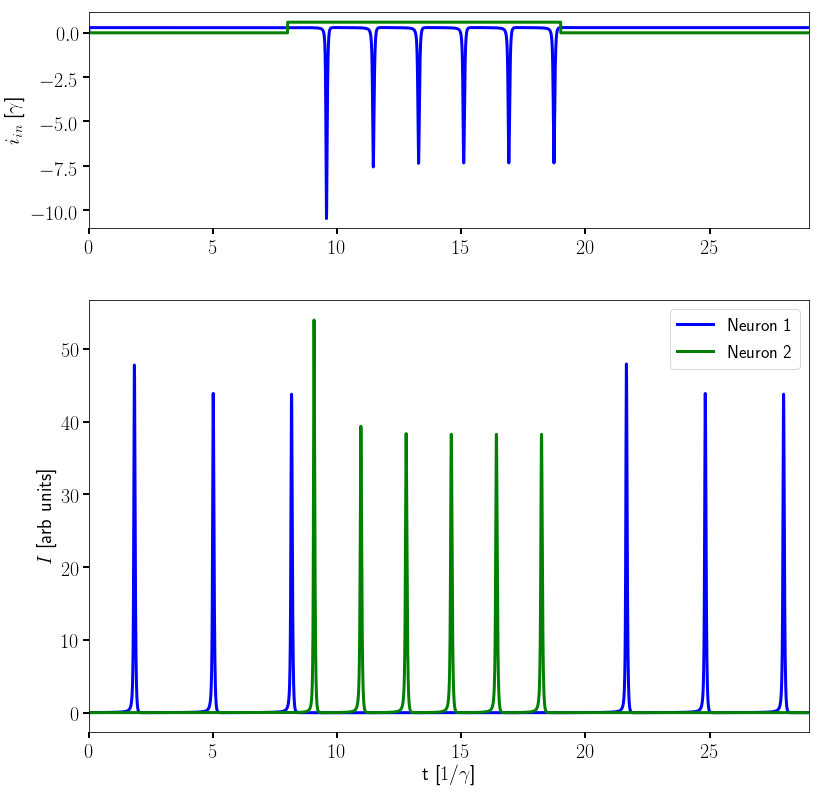

In [23]:
#use visualize_plot to generate a quick plot of the network dynamics
fig2=network2.visualize_plot(input2, output2, time2)

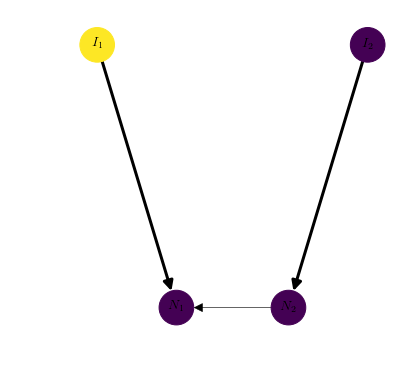

In [9]:
#network2.visualize()
an2 = network2.visualize_animation(inputs=in2, outputs=output2)
HTML(an2.to_html5_video())